In [2]:
#IMPORTING LIBRARIES

import scipy.special as sp # UNUSED?
import numpy as np # NumPy offers comprehensive mathematical functions, random number generators, linear algebra routines, Fourier transforms, and more
import matplotlib.pyplot as plt # Provides a MATLAB-like way of plotting
import pandas as pd # Data analysis and manipulation tool. Used to read in bathymetry data (M77T file), Directions data (excel file), and organises Vmean into a labelled data structure
# M77T data files are created from raw data collected by marine researchers using InfoBank
from scipy.interpolate import CubicSpline as SP # Used to create a spline about the velocity, shape parameter and proability data
from scipy.optimize import minimize,least_squares,Bounds,basinhopping # Optimizing and route finding
from scipy.special import gamma # Gamma function used for weibull distribution
import matplotlib.cm as cm # UNUSED?
from Boruvka_Mod import Graph # imports class graph from Boruvka_Mod python file
import utm # Used to help convert latitude and longitude in bathymetry data to centred eastings and northings
import scipy.interpolate as spline # Used to smooth the bathymetry data
from matplotlib.colors import ListedColormap # UNUSED?
import math # Provides access to the mathematical functions
from time import perf_counter # Returns the float value of time in seconds. Used to record run time for clustering and optimization algorithms
from minmax_kmeans import minsize_kmeans # imports minsize_kmeans function from minmax_kmeans python file
import pulp #Used in the clustering algorithm to generate MPS and LP files
import scipy.signal as signal 
from scipy.signal import savgol_filter
from scipy.interpolate import make_interp_spline, BSpline
from scipy.spatial import ConvexHull
from GP_functions1 import GP_train, GP_predict


In [3]:
# KEY PARAMETERS USED THROUGHOUT MODEL

a = 350 # minimum distances turbines can be from one another in m.
b = 3000 # distance that turbines have negligible affect on eachother in m. If model changes this value could change

maximumturbinespertree = 10 # number of turbines allowed along a single cable from the substation.
budget = np.float64(200000000) # Budget in £ to build the wind farm, accounting for construction costs.
DistanceToShore = 15000 # m #distance of the wind farm from shore
TooCloseShore = 5000 # m # minimum distance the wind farm must be from shore
xCoordOnshoreSub = 0 # x coordinate of the onshore substation (y coordinate is -(DistanceToShore))

USDtoGBP = 1/1.351  
EURtoGBP = 1/1.19

IACableCostperMeter = 409.2*EURtoGBP
ExportCableCostperMeter = 833.625*EURtoGBP

CostperTurbineUSD = np.float64(3000000) # USD
CostperTurbine = CostperTurbineUSD*USDtoGBP # GBP

OperatingandMaintenanceCostsperAnnum = np.float64(65500) # GBP
LifeTimeTurbineOperatingTime = 20 # years 120000 # hours
MaintenanceCostperTurbine = OperatingandMaintenanceCostsperAnnum*LifeTimeTurbineOperatingTime # in GBP

LandCostperHectare = 17245 # in GBP
LandCostpermSquared = LandCostperHectare/10000 #  in GBP

OffshoreSubstationCostperMW = np.float64(104000*EURtoGBP)
OnshoreSubstationCostperMW = np.float64(87250*EURtoGBP)
# Costs  associated with the purchase and installation of electrical substations as well as the buildings required for housing the staff and additional equipment required for the running of the wind farm.

ElectricityCostperkWh = 0.144 # 14.4 pence - £0.144
DiscountRate = 0.07 # 7%

TurbineRating = 2 #2MW

GravityBase = 409000*EURtoGBP*TurbineRating #409000euro/MW
Monopile = 551000*EURtoGBP*TurbineRating
Jacket = 665000*EURtoGBP*TurbineRating
TensionLeg = 1163000*EURtoGBP*TurbineRating

In [4]:
#READING IN BATHYMETRY DATA
data = pd.read_csv("nsea86.m77t", sep='\t') # Reads in all data from file including depth data, lattitude, longitude etc.
mindepth = min(data['CORR_DEPTH']) # Retrieves minimum depth value from data file 'nsea86.m77t'    
print('Shallowest depth:', mindepth, 'm') #Prints out the result for the smallest depth value

Shallowest depth: 17.2 m


In [5]:
###CALCULATES THE INITIAL NUMBER OF TURBINES THE OPTIMISATION SHOULD START WITH.    
maxnodespertree = maximumturbinespertree # As above
minareaperturbine = (1/2)*(math.sqrt(3))*(a**2) # Area per turbine assuming 350m between each turbine
LandCostperTurbine=minareaperturbine*(LandCostpermSquared) # Cost with minimum area
MinDepthCostPerTurbine = CostperTurbine*(0.0002*(float(mindepth)**2) - 0.0002*(float(mindepth)) + 0.9459)-CostperTurbine # Uses shallowest depth from before
print('Min depth cost per turbine = £',MinDepthCostPerTurbine) # prints result
MinIACableCostPerTurbine = a*IACableCostperMeter
MinExportCableCost = TooCloseShore*ExportCableCostperMeter # minimum export cable cost with respect to the minimum distance the wind farm must be form shore
MinFoundationCostPerTurbine = GravityBase*TurbineRating

MinCostperTurbTot = CostperTurbine+LandCostperTurbine+MaintenanceCostperTurbine+MinDepthCostPerTurbine+MinIACableCostPerTurbine+MinFoundationCostPerTurbine # Total costs (excluding export cable and fixed costs)
nnturb = (budget-MinExportCableCost)/MinCostperTurbTot 
FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*nnturb*TurbineRating # *2 due to 2MW turbines being used *0.4 for assuming 40% effciency
nturb = (budget-FixedCost-MinExportCableCost)/(MinCostperTurbTot) # Turbines possible with current budget
nturb = math.floor(nturb) # rounds down as cannot have fraction of a turbine
minarea = minareaperturbine*nturb # Overall minimum area considering the amount of turbines
maxarea = nturb*(1/2)*(math.sqrt(3))*(b**2) # Careful this isn't bigger than the entire size of the scaled nsea86 sea floor.

print('Min area per turbine =', minareaperturbine, 'm^2') # prints results
print('Min area =', minarea, 'm^2')
print('Max number of turbines =', nturb)
print('Max area =', maxarea, 'm^2')

Min depth cost per turbine = £ 3615.099925980903
Min area per turbine = 106088.11196359372 m^2
Min area = 3713083.91872578 m^2
Max number of turbines = 35
Max area = 272798002.19209814 m^2


In [6]:
#PRE-OPTIMISATION TURBINE POSITIONING

# places substation at (0,0).
# places 1st turbine at vector (a,0) from substation. a=350m from before
# places 2nd turbine at vector (0.5a,0.5aroot3) from prev. 
# places 3rd turbine at vector (-a,0) from prev
# places 4th turbine at vector (-0.5a,-0.5aroot3) from prev, continues in this spiralling fashion

positionlist = np.empty((nturb+1,2)) # Creates an empty list of size (number of turbines + 1 (since 0 position is substation),2)
turbineposition = np.array([[0,0]]) # Creates [0,0] array for introducing [x,y] coordinates for each turbine
positionlist[0,:] = turbineposition # 

oddcounter = 0
evencounter = 0
i = 0
k = 0

while k<nturb+1: # Loops for number of turbines 
    i += 1
    if (i%2)!= 0: # i is odd
        oddcounter+=1
        for j in range(oddcounter):
            k += 1
            if k == nturb+1:
                break
            if (oddcounter%2)!= 0: #oddcounter is odd
                shift = np.array([[a, 0]])
            else:
                shift = np.array([[-a, 0]])
            turbineposition = np.add(turbineposition, shift)
            positionlist[k,:] = turbineposition
        
    else:
        evencounter+=1
        for j in range(evencounter):
            k += 1
            if k == nturb+1:
                break
            if (evencounter%2)!= 0: #evencounter is odd
                shift = np.array([[0.5*a,0.5*a*math.sqrt(3)]])
            else:
                shift = np.array([[-0.5*a,-0.5*a*math.sqrt(3)]]) 
            turbineposition = np.add(turbineposition, shift)
            positionlist[k,:] = turbineposition
                
print(positionlist) # prints positions data        
print(len(positionlist)) # prints length of positions list (should be the number of turbines + 1 for the subsation)

[[    0.             0.        ]
 [  350.             0.        ]
 [  525.           303.10889132]
 [  175.           303.10889132]
 [ -175.           303.10889132]
 [ -350.             0.        ]
 [ -525.          -303.10889132]
 [ -175.          -303.10889132]
 [  175.          -303.10889132]
 [  525.          -303.10889132]
 [  700.             0.        ]
 [  875.           303.10889132]
 [ 1050.           606.21778265]
 [  700.           606.21778265]
 [  350.           606.21778265]
 [    0.           606.21778265]
 [ -350.           606.21778265]
 [ -525.           303.10889132]
 [ -700.             0.        ]
 [ -875.          -303.10889132]
 [-1050.          -606.21778265]
 [ -700.          -606.21778265]
 [ -350.          -606.21778265]
 [    0.          -606.21778265]
 [  350.          -606.21778265]
 [  700.          -606.21778265]
 [  875.          -303.10889132]
 [ 1050.             0.        ]
 [ 1225.           303.10889132]
 [ 1400.           606.21778265]
 [ 1575.  

In [7]:
# Shoreline implementation

XShoreLine = np.array([np.linspace(min(positionlist[:,0])-2500,max(positionlist[:,0])+2500,1000)]) #Creates x coordinates of shoreline bewtween min and max turbine locations +/- 1000m # 1000 data points
YShoreLine = np.array([np.linspace(-DistanceToShore,-DistanceToShore,1000)]) #Creates y coordinates of shoreline at -(distance of the wind farm from the shore) # 1000 data points
TXShoreLine = np.transpose(XShoreLine) #transpose of x coordinates
TYShoreLine = np.transpose(YShoreLine) #transpose of y coordinates
TShoreLine = np.concatenate((TXShoreLine,TYShoreLine),axis=1) # Shoreline (x,y)

In [8]:
# Finds distance between substation and shore

def Substation_To_Shore_Connection(positionlist):
    
    OnshoreSubstation = [xCoordOnshoreSub,-DistanceToShore] # Determines fixed position of onshore substation
    ExportDistance = np.sqrt(((positionlist[0,0]-OnshoreSubstation[0])**2)+((positionlist[0,1]-OnshoreSubstation[1])**2)) # min Hypotenuse for distances between substations
    
    return OnshoreSubstation,ExportDistance

OnshoreSubstation,ExportDistance = Substation_To_Shore_Connection(positionlist) #Initially Executes algorithm

print(OnshoreSubstation)
print(np.shape(OnshoreSubstation))
print(ExportDistance)

[0, -15000]
(2,)
15000.0


In [9]:
# Pushes wind farm further out if the smallest distance between the shore and center of wind farm is too small
# Only used for the pre-optimised layout
#In terms of keeping it this way there are bounds on (minimize(targetfunction, initial guess, bounds,.....etc.) the optimization function

CloseTurbY = min(positionlist[:,1]) # y coordinate of closest turbine
CloseTurbYindex = np.argmin(positionlist[:,1]) # index from closest turbine on y axis
CloseTurbX = positionlist[CloseTurbYindex,0] # x coordinate of closest turbine on y axis
DistanceToMinTurb = min(np.sqrt((CloseTurbX-TXShoreLine[:,0])**2+(CloseTurbY-TYShoreLine[:,0])**2)) #min distance from shore to closest turbine 
s = 0

if DistanceToMinTurb < TooCloseShore: # if closest turbine is too close to the shore
    for s in range(0,nturb+1): # loops for number of turbines plus the substation
        positionlist[s,1] = positionlist[s,1] + (TooCloseShore-DistanceToMinTurb)
        # Shifts entire wind farm up by the difference to achieve the minimum distance required
    Substation_To_Shore_Connection(positionlist) #Calls function to redo substation to shore connection with new values

(-16606.217782649106, -706.217782649107)

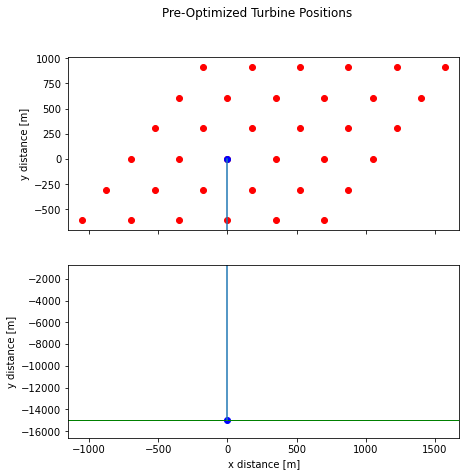

In [10]:
# Display pre-optimized turbine positions before clustering and MST

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)    
ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue') # offshore Substation
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_xlabel('x distance [m]') # x axis label
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

In [11]:
#Function to determine land cost of wind farm using a convex hull
#Calcualtes area of wind farm, onshore substation, and export cable
#Won't work for just 1 turbine since no boundary to enclose

def LandAreaCost(positionlist,ExportDistance):
    
    radius = 130 #m
    OnshoreSubLand = np.pi*radius**2 #Land area associated with the onshore substation
    ExportLand = ExportDistance*8 # Length*width 
    
    hull = ConvexHull(positionlist) #computes convex hull using the turbine positions
    LandArea = hull.volume + OnshoreSubLand + ExportLand #Calcualtes convex hull area and adds on the onshore substation land area

    LandCost = LandArea*LandCostpermSquared
    
    return LandCost

LandCost = LandAreaCost(positionlist,ExportDistance)

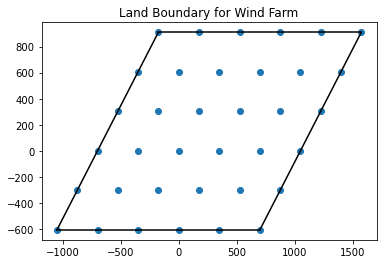

In [12]:
#Visual aid for convex hull plotting

hull = ConvexHull(positionlist)
plt.plot(positionlist[:,0], positionlist[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(positionlist[simplex, 0], positionlist[simplex, 1], 'k-')


plt.title('Land Boundary for Wind Farm')
plt.show()

 C:\Users\adamb\anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning:Spaces are not permitted in the name. Converted to '_'


Function run time: 0.23736970000000213
[[   0    2    3    4   14   15   16   33   34   35 -100]
 [   0   11   12   13   28   29   30   31   32 -100 -100]
 [   0    5    6    7   17   18   19   20   21   22   23]
 [   0    1    8    9   10   24   25   26   27 -100 -100]]


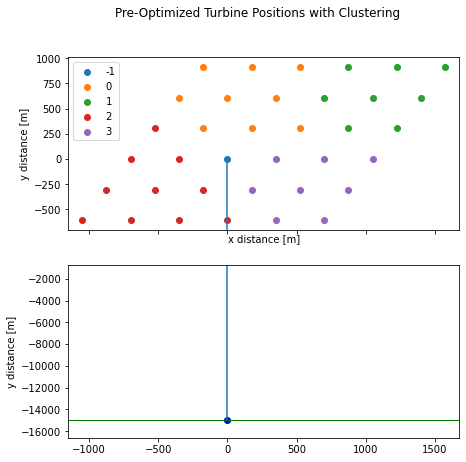

In [13]:
#CLUSTERING ALGORITHM

#Uses an adapted version of kmeans with a cap on the number of points per cluster. Used to radially cluster turbines
#into segments which MST algorithm can then use to determine cabling for a given radial array. Initially unnecessary
#for the initially structured turbine layout as seen above, but increasingly important as turbine layout becomes
#non-uniform through optimisation when the below function is repeatedly called.
# minsize_kmeans imported from external python file

def clustering_algorithm(positionlist,nturb,maxnodespertree):
    k = math.ceil(nturb/maxnodespertree) #number of clusters. math.ceil rounds a number upwards to its nearest integer
    [turbines, centres] = minsize_kmeans(positionlist[1:,:] ,k ,min_size = 1, max_size = maxnodespertree) 
    #turbines exists as an array containing the cluster value for each turbine
    #Assigns each turbine to a cluster. excludes substation, executes external python file, 
    #limits for how many turbines are in each cluster between 1 and max nodes per tree 
    label = np.concatenate((np.array([-1]),turbines)) # Adds -1 (substation label) to the other turbine labels
    u_labels = np.unique(label) 
    # finds unique elements of label. Finds the unique cluster labels 
    # each turbine is assigned a cluster/label and this returns a single label for each cluster
    
    a = 0
    indiceslist = np.empty((k,maxnodespertree), dtype=np.int8) # empty array of no.clusters by max nodes per tree
# indiceslist basically tells us what turbines belong to each cluster
# each row of indiceslist represents a cluster and each point on that row a indidual turbine within that cluster
# Each row starts with a 0 which represents the subsation which belongs to all clusters
# As seen before in the initial layout numbers are assigned starting at 1 which is the turbine (a,0) from the substation
# The numbering then continues in a cyclic motion traveling anticlockwise up until the total number of turbines
    
    for i in range(k): # loops for number of clusters
        indices = [i for i, x in enumerate(label) if x == a] # enumerate exists as a counter in the loop (starts at x=a=0)

        if len(indices) < maxnodespertree:
            noofemptys = maxnodespertree - len(indices)
            for l in range(noofemptys): # For the empty spaces in the matrix replaces these with -100 as fillers
                indices.append(int(-100))
    
        indiceslist[i,:] = (indices)
        a += 1
    
    arr = np.zeros((k,1),dtype=np.int8)   # zero array of number of clusters by 1 (Substation array)
    indiceslist = np.concatenate((arr,indiceslist),axis=1) # Adds substation zero array to turbine cluster matrix
    return indiceslist,u_labels,label

t1_start = perf_counter() # Starts timer
indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree) #Executes clustering algorithm
t1_stop = perf_counter() # Ends timer
print('Function run time:', t1_stop-t1_start) # Prints algorithm run time

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions with Clustering')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
for i in u_labels: # loops for number of turbines
    ax1.scatter(positionlist[label == i , 0] , positionlist[label == i, 1] , label = i)
ax1.legend() # prints legend
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_xlabel('x distance [m]') # x axis label
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

print(indiceslist)

In [14]:
#CREATES INPUT NEEDED FOR MST ONCE CLUSTERS ARE DEFINED.

#distance_global - distances of each turbine with respect to the substation and each other h=sqrt(x^2+y^2)
#e.g. row 0 would be each turbines distance with respect to the substation
# and row 4 would be each turbines distance with respect to the 4th turbine as found in the position list
# distance_globl[i,i] = 1e10 since this is the distance of each turbine with respect to itself so we want the MST to ignore thse values
#angle_global - angle of each turbine with respect to the substation and each other arctan(y/x)
#distance and angle then do something similar but considering the cluster formations as well

def geom_analysis(positionlist,indiceslist):
    
    #Arrays for pairwise distances and angles
    #Angle 0: x directıon. Angle pi/2: y directıon
    distance = [None] * math.ceil(nturb/maxnodespertree) # null array with size based on number of clusters
    angle = [None] * math.ceil(nturb/maxnodespertree) 
    distance_global = np.zeros((nturb,nturb)) #zero array nturb by nturb. This will be for storing the distance between each pair of turbines for cabling
    angle_global = np.zeros((nturb,nturb)) # Like above this will be for storing the angle data between each pair of turbines for cabling
    coords = positionlist[1:,:] # Coordinates of each turbine

    for i in range(0,nturb): # loops for number of turbines
        distance_global[i,:]=np.sqrt(np.square(coords[i,0]-coords[:,0])+np.square(coords[i,1]-coords[:,1])) # Pythagoras for hypotenuse
        angle_global[i,:]=np.arctan2(coords[:,1]-coords[i,1],coords[:,0]-coords[i,0]) #Pythagoras for angle
        distance_global[i,i]=1e10
        #Rotate angles so that north=0 and convert to degrees
    angle_global=-np.rad2deg(angle_global)+270
    
    for x in range(0,math.ceil(nturb/maxnodespertree)): # loops for number of clusters
        nturbintree = np.count_nonzero(indiceslist[x,:] > -1) # Everything except the -100 ones which were denoted earlier to show that there is no turbine at that index
        distance[x]=np.zeros((nturbintree,nturbintree))
        angle[x]=np.zeros((nturbintree,nturbintree))
    
        for i in range(0,nturbintree):
            for j in range(0,nturbintree):
                distance[x][i,j] = np.sqrt(np.square(positionlist[(indiceslist[x,i]),0]-positionlist[(indiceslist[x,j]),0]) + np.square(positionlist[(indiceslist[x,i]),1]-positionlist[(indiceslist[x,j]),1]))
                angle[x][i,j]=np.arctan2(positionlist[(indiceslist[x,j]),1]-positionlist[(indiceslist[x,i]),1],positionlist[(indiceslist[x,j]),0]-positionlist[(indiceslist[x,i]),0])
                distance[x][i,i]=1e10
        
        #Rotate angles so that north=0 and convert to degrees
        angle[x]=-np.rad2deg(angle[x])+270
      
    return distance,angle,distance_global,angle_global

In [15]:
# DETERMINES MINIMUM LENGTH OF CABLING REQUIRED TO CREATE COMPLETE CABLING NETWORK SUCH THAT ALL TURINES ARE CONNECTED
# IN ACCORDANCE WITH USER'S CONDITIONS.

def Minimum_Spanning_Tree(distance,indiceslist):

    MSTweight = [None] * math.ceil(nturb/maxnodespertree) # null array with sized based on number of clusters
   
    for x in range(0,math.ceil(nturb/maxnodespertree)): #loops for number of clusters
        nturbintree = np.count_nonzero(indiceslist[x,:] > -1)
        g=Graph(nturbintree) #Graph is part of the external python script titled Boruvka_Mod
        
        for i in range(0,nturbintree):
            for j in range(i+1,nturbintree):
                g.addEdge(i,j ,(distance[x][i,j]*1000))
           
        MSTweight[x]=g.boruvkaMST()
    return MSTweight

Each tree weight tree 1 3150000.0
Each tree weight tree 2 3376012.958872607
Each tree weight tree 3 3500000.0
Each tree weight tree 4 2800000.0
MST total weight 12826012.958872607 m


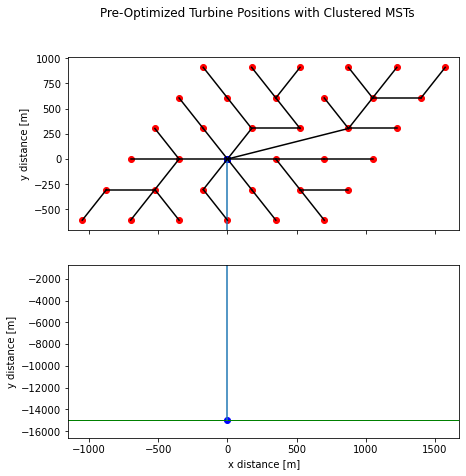

In [16]:
#PLOTTING PRE-OPTIMISED MST

# the Boruvka_mod code requires graphs with vertices 0....n, which is provided by the index value on indices list.
# When this is plotted, the values within the correct indiceslist row are then used to reference the index within
# positionlist to be plotted.

#

MSTweight=Minimum_Spanning_Tree(geom_analysis(positionlist, indiceslist)[0],indiceslist)

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions with Clustered MSTs')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_xlabel('x distance [m]') # x axis label
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

links = [None] * math.ceil(nturb/maxnodespertree)
MSTWeightSum = 0 #MST weight is simply the total length of cabling used

for a in range(0,math.ceil(nturb/maxnodespertree)):
    MSTWeightSum += MSTweight[a][0]
    print('Each tree weight', 'tree',a+1 ,MSTweight[a][0])
    links[a] = MSTweight[a][1]
    
    for b in links[a]:
        u = positionlist[(indiceslist[a,b[0]])][0], positionlist[(indiceslist[a,b[1]])][0]
        v = positionlist[(indiceslist[a,b[0]])][1], positionlist[(indiceslist[a,b[1]])][1]
        ax1.plot(u,v, c='black')
        ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue')
        
print('MST total weight', MSTWeightSum, 'm')

In [17]:
#DISPLAYS RAW BATHYMETRY DATA

#print(data) # Prints out bathymetry data - Read in using pandas in previous section

In [18]:
#CONVERTS LATITUDE AND LONGITUDE IN BATHYMETRY DATA TO CENTERED EASTINGS AND NORTHINGS

data['easting'] = data.apply(lambda row: utm.from_latlon(row['LAT'], row['LON'])[0], axis=1) #Converts lon/lat to easting and adds this onto the 'data' file
data['northing'] = data.apply(lambda row: utm.from_latlon(row['LAT'], row['LON'])[1], axis=1) #Converts lon/lat to northing and adds this onto the 'data' file

zero_east = min(data['easting']) + (max(data['easting']) - min(data['easting']))/2 +30000 # Determines centre of bathymrtry data in easting direction (+30,000 is simply to get a more interesting result from the current bathymetry data)
zero_north = min(data['northing']) + (max(data['northing']) - min(data['northing']))/2 # Determines centre of bathymetry data in northing direction   

data['centered_easting'] = data['easting'] - zero_east # Centres the data about (0,0) and adds this onto the 'data' file
data['centered_northing'] = data['northing'] - zero_north # Centres the data about (0,0) and adds this onto the 'data' file

#print(data) 

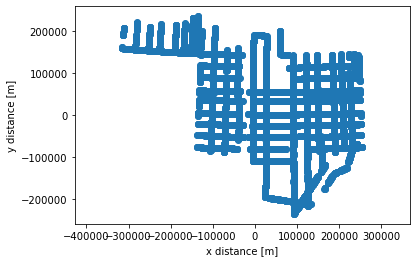

In [19]:
#PLOTS CENTERED BATHYMETRY DATA

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

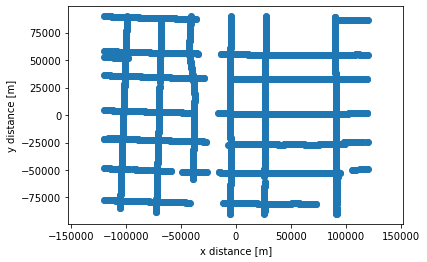

In [20]:
# SAMPLING AND PLOTTING CENTRAL BATHYMETRY DATA
# Takes sample between +/-120000 in easting direction, +/-90000 in the northing direction, and +/-1000 for the depth values

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
data = data[(data['centered_easting'] >=-120000) & (data['centered_easting'] <= 120000) & (data['centered_northing']>=-90000) & (data['centered_northing']<= 90000) & (data['CORR_DEPTH']<=1000) & (data['CORR_DEPTH']>=-1000)]
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

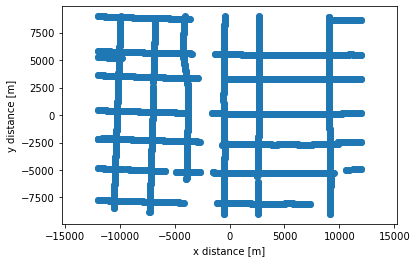

In [21]:
#FURTHER BATHYMETRY DATA PROCESSING
#Further decreases the area considered to be more applicable to the size of the wind farm (Sample from before divided by 10 in northing and easting directions)

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
data['centered_easting'] = data['centered_easting']/10
data['centered_northing'] = data['centered_northing']/10
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

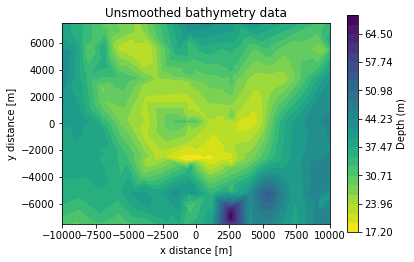

In [22]:
#UNSMOOTHED BATHYMETRY DATA CONTOUR PLOTTING

fig, ax = plt.subplots()
plt.xlim([-10000, 10000]) # x Limits of plot between +/-10000
plt.ylim([-7500, 7500]) # y Limits of plot between +/-7500
ax.set_aspect(aspect=1) # Sets the aspect of the axis scaling, i.e. the ratio of y-unit to x-unit.
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')

maxdepth = max(data['CORR_DEPTH'])
levels = np.linspace(mindepth,maxdepth,24) # Creates 24 even spaces or levels between the min and max depth

tcf = ax.tricontourf(data['centered_easting'], data['centered_northing'], data['CORR_DEPTH'], levels=levels, cmap = 'viridis_r') # (x,y,colour bar factor,level values,colour scale)
cbar = plt.colorbar(tcf)
cbar.set_label('Depth (m)')
ax.set_title('Unsmoothed bathymetry data');

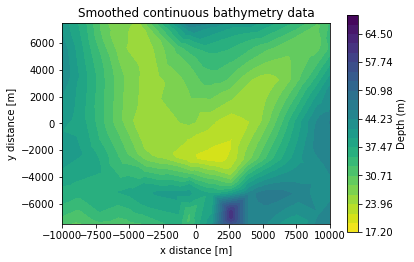

In [23]:
#SMOOTHING BATHYMETRY DATA

smooth = spline.SmoothBivariateSpline(data['centered_easting'], data['centered_northing'], data['CORR_DEPTH'], s = 25000)

fig, ax = plt.subplots()
plt.xlim([-10000, 10000])
plt.ylim([-7500, 7500])
ax.set_aspect(aspect=1)
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
levels = np.linspace(mindepth,maxdepth,24)

tcf = ax.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')
cbar = plt.colorbar(tcf)
cbar.set_label('Depth (m)')
ax.set_title('Smoothed continuous bathymetry data');

In [24]:
# DETERMINING DEPTH AND ASSOCIATED COST FOR EACH TURBINE

def depthvalues(positionlist):
    DepthPerTurbine = [None] * (len(positionlist)-1) # none defines a null/no value. Get a null list the size of the np. turbines
    DepthCostPerTurbine = [None] * (len(positionlist)-1) # Get a null list the size of the number of turbines
    DepthCostAllTurbines = np.float64(0) # Assigns initial value to variable

    for i in range(0,len(positionlist)-1): # loops for amount of turbines
        DepthPerTurbine[i] = spline.SmoothBivariateSpline.ev(smooth, positionlist[i+1,0], positionlist[i+1,1]) # Acquires depth assigned to each turbines position (x,y)
        DepthCostPerTurbine[i] = MinDepthCostPerTurbine = CostperTurbine*(0.0002*(float(DepthPerTurbine[i])**2) - 0.0002*(float(DepthPerTurbine[i])) + 0.9459)-CostperTurbine #Formula for depth cost
        DepthCostAllTurbines += DepthCostPerTurbine[i] # Sums up all turbines depth costs
        
    mindepth=float(min(DepthPerTurbine))
    maxdepth=float(max(DepthPerTurbine))
    return DepthCostAllTurbines, mindepth, maxdepth # returns respective values to user

depthvalues(positionlist)

(5634628.501841279, 23.394764925387133, 27.392063228618998)

In [25]:
smooth

In [26]:
#SETTING MODEL PARAMETERS

v0=8.0  #Incoming wind speed
nwind = 33
wind=np.arange(254,287)

#b=np.array((1,5,1000))
#b=np.array(( 1.40002561e-01,   8.51478121e+00,   2.62606729e+03))

# 3 model parameters below:

# 0th: how much power the turbine removes at the centre of the peak of the power distribution.
# 1st: how wide the angle of effect is. UNITS: degrees
# 2nd: up to how far back the effect takes place (approx. 2.6km) UNITS: [m]

model=np.array((1.39998719e-01, 8.51483871e+00, 2.62613638e+03))

ws=2.0 #weibull scale factor
wei_gamma=gamma(1.+1./ws)

Pr = 2*10**6 #Rated Power for Horns Rev 1 Turbines. Max power output [Watts]
Vc = 4.0 #Cut-in Velocity. Starts producing energy at wind speed of 4m/s [m/s]
Vr = 15.0 #Rated Velocity. Starts producing max energy at 15m/s
Vf = 25.0 #Cut-off Velocity. Turbines cut out at wind speeds of 25m/s to prevent damage to the turbines.
k = 2.0 #Weibull shape parameter
(Pr,Vc,Vr,k)

#interpolation parameters
dvel=1.5 #[m/s]
dang=1. #[degrees]

In [27]:
#DETERMINING WIND DIRECTION AND VELOCITY AT HORNS REV 1

v=np.loadtxt('hornsrev_data_all.txt') # assigns data to variable v.
vxref=v[:,3] # (INDEXING STARTS FROM 0). Third column of data is velocity of wind in x direction.
vyref=v[:,4] # (INDEXING STARTS FROM 0). Fourth column of data is velocity of wind in y direction.
angles=v[:,0] # Zeroth column of data is wind angle.
vmean=np.sqrt(np.square(vxref)+np.square(vyref)) # Uses pythagoras to find the wind magnitude + direction for each location.

vmean=pd.DataFrame(vmean) # organises vmean into labelled data structure
vref=pd.DataFrame()

vmean['angle']=angles # add another column to vmean (angle)
vref=vref.append(vmean) # add empty pandas data frame

vref=vref.groupby('angle')
vref.groups
vref.describe()
vref.get_group(260).iat[50,0] # data manipulation to group by angle etc.

6.512913707119303

In [28]:
#Arrays for pairwise distances and angles
#Angle 0: x direction. Angle pi/2: y directıon

# calculates distance and angle between each pair of turbines:

distance=np.zeros((nturb,nturb)) # 2x2 matrix of distances between turbines i and j where distance i-i and distance j-j = 0
# as they're distances to themselves: i-i i-j
                                 #    j-i j-j

angle=np.zeros((nturb,nturb)) # same as above but for angles between turbines.

for i in range(0,nturb):
   
    # 80x80 matrices as there's 80 turbines at Horns Rev 1.
    # squares y distance and x distance then sqrt to find overall distance between 2 turbines.
    distance[i,:]=np.sqrt(np.square(positionlist[i+1,0]-positionlist[1:,0])+np.square(positionlist[i+1,1]-positionlist[1:,1]))
    # same as above using arctan2 whilst giving correct quadrant (between 2 turbines).
    angle[i,:]=np.arctan2(positionlist[1:,1]-positionlist[i+1,1],positionlist[1:,0]-positionlist[i+1,0])
# Rotate angles so that north=0 and convert to degrees (and clockwise instead of anticlockwise)
angle=-np.rad2deg(angle)+270

# Rotating angles to wind direction
windangle=1 # degrees
rotangles=np.mod(angle-windangle+180,360)-180

In [29]:
# IMPORTING WIND DIRECTION DATA

#meteorological data where north = 0 degrees)
directiondata = pd.read_csv ('Directiondata.csv')
print (directiondata)
# velocity is the mean velocity with which wind from this direction blows
# c determines how wide the distribution is
# frequency/100 determines how often the wind is blowing at this angle

    Angle  Velocity     c  frequency
0       0      8.89  2.09       4.82
1      30      9.27  2.13       4.06
2      60      8.23  2.29       3.59
3      90      9.78  2.30       5.27
4     120     11.64  2.67       9.12
5     150     11.03  2.45       6.97
6     180     11.50  2.51       9.17
7     210     11.92  2.40      11.84
8     240     11.49  2.35      12.41
9     270     11.08  2.27      11.34
10    300     11.34  2.24      11.70
11    330     10.79  2.19       9.69
12    360      8.89  2.09       4.82


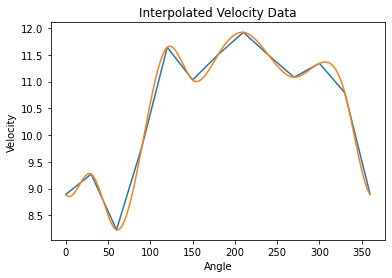

In [30]:
# interpolate 'velocity'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['Velocity']
wbvel = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360,0.10)
plt.plot(x,y, label='Line')
plt.plot(xs, wbvel(xs), label="Interpolated line ")
plt.title('Interpolated Velocity Data')
plt.xlabel('Angle')
plt.ylabel('Velocity')
plt.show()
# blue lines shows linear interpolation, orange shows smooth interpolation including across the
# periodic boundary.

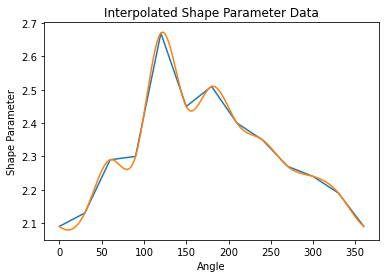

In [31]:
#interpolate 'c'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['c']
wbshape = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360, 0.1)
plt.plot(x,y)
plt.plot(xs, wbshape(xs), label="S")
plt.title('Interpolated Shape Parameter Data')
plt.xlabel('Angle')
plt.ylabel('Shape Parameter')
plt.show()

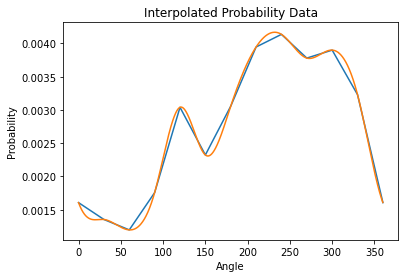

In [32]:
#interpolate 'frequency'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['frequency']/(100.*30.) #Data is in percent per 30 degrees, changing to probability per degree


windfreq = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360, 0.1)
plt.plot(x,y)
plt.plot(xs, windfreq(xs), label="S")
plt.title('Interpolated Probability Data')
plt.xlabel('Angle')
plt.ylabel('Probability')
plt.show()
# plot shows wind direction is predominantly 200-320deg.

In [33]:
# Simple Attenuation fn
# Determines how much wind there is AFTER a turbine.
def att(dist, ang, model): 
        # 'Model' parameters are defined in 2ND CELL.

    # angular part
    angular=np.where(2.*model[1]*np.abs(ang)<np.pi,np.square(np.cos(model[1]*ang)),0.)
    # angular = np.cos(model[1]*ang WHEN 2.*model[1]*np.abs(ang) is less than pi, else angular = 0.
    
    # radial part (distance) (Gaussian Function)
    radial=np.exp(-np.square(dist/model[2])) # decreasing exponential of square, scaled by 2nd parameter
    penalty=np.exp(-np.square(dist/200))
    #penalty = 0
    return 1.0-1*model[0]*angular*radial-2*model[0]*penalty # OUTCOME

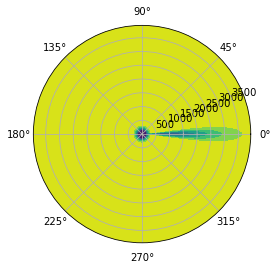

0.580003843


In [34]:
azimuths = np.radians(np.linspace(0, 360, 360)) # angles theta from 0 to 360 degress in 1 degree increments. Grid
zeniths = np.arange(0, 4000, 50) # distance from 0 to 4000 broken up into increments of 50.

r, theta = np.meshgrid(zeniths, azimuths)
values = att(r,np.mod(theta+np.pi,np.pi*2)-np.pi,model) # gets angles from -pi to pi, not from 0 to 2pi.

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.contourf(theta, r, np.maximum(values,0.85*np.ones(np.shape(values))))

plt.show()
print(np.min(values))

## Cell description:
# Polar plot is for 1 turbine, blue area shows where wind speed is affected. (Numbers label distance from turbine).
# Across the curve the distribution is the hump of cosine^2 function.
# Radially the distribution shown is Gaussian.
# Wake is currently too narrow close to the turbine as it treats the turbine as a point rather than accommodating
# for the blades' diameter.

In [35]:
# # isn't useful for continuing code, just rotates the windfarm.
# def rotate(angle,coords):
#     angle = np.pi*angle/180.
#     rotcoordx = []
#     rotcoordy = []
#     for coord in coords:
#         rotcoordx+=[coord[0]*np.cos(angle)-coord[1]*np.sin(angle)]
#         rotcoordy+=[coord[0]*np.sin(angle)+coord[1]*np.cos(angle)]
#     rotcoords=[rotcoordx,rotcoordy]
#     rotcoords=np.array(rotcoords).T   
#     return rotcoords 
# #print rotate(254,coords)[:,0]
# plt.scatter(rotate(0,coords)[:,0],rotate(0,coords)[:,1])

In [36]:
# returning total deviation between model and training set (between CFD data and the attenuation model)
# This was relevant for earlier stages of the project when the wake model was being developed
#Total att
def deviation(b):
    total_att=np.ones((nturb,nwind))
    deviation=0
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]*att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,b)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            deviation=deviation+np.square(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return deviation

In [37]:
# returning deviation for each turbine.
# This was relevant for earlier stages of the project when the wake model was being developed
#Total att
def deviation_sq(model):
    total_att=np.ones((nturb,nwind))
    dev_vec=np.zeros((nturb*nwind))
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]* att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,model)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            dev_vec[nturb*k+j]=(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return dev_vec

In [38]:
## (USED IN TARGET FUNC)
# Calculates the power produced by turbines when it sees a certain wind speed at a certain angle. 3D matrix
def power(wsr,v): # wind speed reduction, velocity
    nvel=np.size(v)
    nangle=np.size(wsr,1)
    power_vec=np.zeros((nturb,nangle,nvel))
    power_vec=POvec(np.outer(wsr,v)).reshape(nturb,nangle,nvel) # np.outer takes every wsr element and individually multiplies it with every element of v.
    return power_vec

In [39]:
## GIVES PROBABILITY OF WIND SPEED V AT A GIVEN ANGLE
def windspeedprobability(angles,v,d_angle,d_vel):
    nvel=np.size(v) 
    nangle=np.size(angles)
    wsprob=np.zeros((nangle,nvel))
    for i in range(angles.shape[0]):
        # Get Weibull parameters for angle and evaluate probability
        wsprob[i,:]=(wei(v[:],wbvel(angles[i]),wbshape(angles[i])))*windfreq(angles[i])*d_angle*d_vel
    return wsprob

In [40]:
# DEFINES WEIBULL DISTRIBUTION (shows the probability of any given wind speed occuring).

def wei(x,n,k): # convention to have in this order, scale parameter comes first (x) 
    u=n/gamma(1+1/k) #scaled wind speed
    return (k / u) * (x / u)**(k - 1) * np.exp(-(x / u)**k)
# k = Weibull shape parameter
# n = scale parameter
# x= value we are valuating

In [41]:
def wind_dist(v,vm):
    return wei(v,vm,k)

In [42]:
wind_dist(1.0,v0)

0.024244336764100854

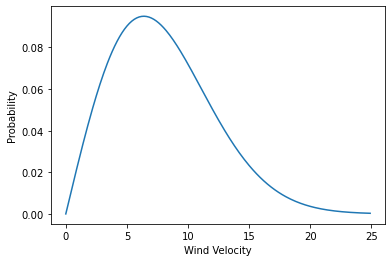

In [43]:
# PLOTS WEIBULL DISTRIBUTION

x=np.arange(0,25,0.1)
y=wind_dist(x,v0)

plt.xlabel('Wind Velocity')
plt.ylabel('Probability')
plt.plot(x,y)

In [44]:
velocities=np.arange(Vc,Vf,dvel) # 1D array ranging from Vc to Vf in dvel intervals. 4 to 25 in steps of 1.5
angles=np.arange(0,360,dang) # 0 to 360 with intervals of dang.
wsp=windspeedprobability(angles,velocities,dang,dvel) # tells probability of getting wind from a certain direction with a certain velocity.
# sum of all numbers would add up to 1.
print(wsp,np.shape(wsp),np.sum(wsp)) # wsp array, shape of wsp (rows,columns), sum of wsp elements
print(np.shape(velocities)) # shape of velocities array (rows, columns)
#plt.plot(x,y)
print(angles)
print(velocities)
print(dang)

[[1.59060699e-04 1.96007335e-04 2.11578542e-04 ... 1.27838162e-05
  6.80507775e-06 3.41260914e-06]
 [1.56465075e-04 1.92559460e-04 2.07592321e-04 ... 1.23862930e-05
  6.58387507e-06 3.29691036e-06]
 [1.53947090e-04 1.89262844e-04 2.03838173e-04 ... 1.20685507e-05
  6.41067838e-06 3.20821779e-06]
 ...
 [1.67155160e-04 2.07084717e-04 2.24776660e-04 ... 1.45197853e-05
  7.80022752e-06 3.94871037e-06]
 [1.64425241e-04 2.03294441e-04 2.20197084e-04 ... 1.38475351e-05
  7.41087064e-06 3.73685128e-06]
 [1.61720431e-04 1.99593425e-04 2.15788233e-04 ... 1.32697355e-05
  7.07987732e-06 3.55867652e-06]] (360, 14) 0.9458659673419384
(14,)
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.

In [45]:
# CALCULATES THE POWER CURVE OF A TURBINE

# Plots the power curve of a turbine.
# No power output from 0-4m/s, then cubic rise up to 15m/s and stays
# constant until cut-off velocity of 25m/s.

#cubic Based Power output
a=Pr/(Vr**3-Vc**3)
b=Vc**3/(Vr**3-Vc**3)

def q(v): # q is power output

    if (v<Vc): # below cut in velocity power is 0.
        q=0
    elif (v<Vr):
        q=a*v**3-b*Pr # cubic power output between cut in and max.
    elif (v<Vf):
        q=Pr # max power between max and cut off velocity.
    else: 
        q=0 # no power above cut off velocity.
    return q

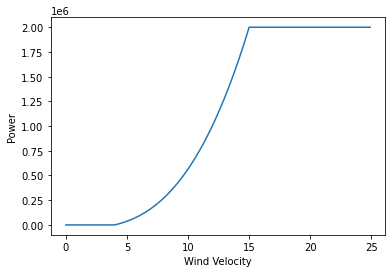

In [46]:
#PLOTS TURBINE POWER CURVE

x=np.arange(0,25,0.1)
POvec=np.vectorize(q) # vectorises power output function q (from cell above).
y=POvec(x)

plt.xlabel('Wind Velocity')
plt.ylabel('Power')
plt.plot(x,y)

In [47]:
# EXPECTED TURBINE OUTPUT (Watts) for the given wind distribution and positions.
# Can be seen that top left (NW) produces most energy for Horns Rev 1 Wind Farm.

# EXPECTED POWER FROM WIND FARM CALCULATIONS
# multiply the power that you'd get for each wind angle and speed condition by the probability of this occuring, for all angles and speed
# values and sum to find the expected power.
# Sum up this value for all turbines to find total wind farm expected power output.
# output=np.zeros((nturb)) 
# output=np.tensordot(powout,wsp,2)
# print(output,np.shape(output),np.sum(output))
# last output is total power output in Watts.

In [48]:
# TURBINE OUTPUT (Watts) WITH NO INTERFERENCE

#Reference output:
# Same calculations as cell above except each turbine sees the full amount of wind every time
# (i.e. no wind reduction from other turbines).
refpowout=power(np.ones((nturb,np.size(angles))),velocities)
refoutput=np.zeros((nturb))
refoutput=np.tensordot(refpowout,wsp,axes=2)
print(refoutput,np.shape(refoutput),np.sum(refoutput))

# last output is total power output in Watts.

[867160.41553869 867160.41553869 867160.41553869 867160.41553869
 867160.41553869 867160.41553869 867160.41553869 867160.41553869
 867160.41553869 867160.41553869 867160.41553869 867160.41553869
 867160.41553869 867160.41553869 867160.41553869 867160.41553869
 867160.41553869 867160.41553869 867160.41553869 867160.41553869
 867160.41553869 867160.41553869 867160.41553869 867160.41553869
 867160.41553869 867160.41553869 867160.41553869 867160.41553869
 867160.41553869 867160.41553869 867160.41553869 867160.41553869
 867160.41553869 867160.41553869 867160.41553869] (35,) 30350614.543854177


In [49]:
# # assigns smaller interpolation intervals to dvel and dang to compare to coarser interpolations.
# dvel=0.1
# dang=0.1
# velocities=np.arange(Vc,Vf+dvel,dvel)
# angles=np.arange(0,360,dang)
# wsp=windspeedprobability(angles,velocities,dang,dvel)
# wsr=windspeedreduction(distance,angle,angles,model)
# powout=power(wsr,velocities)
# output=np.zeros((nturb)) 
# output=np.tensordot(powout,wsp,2)
# print (dvel,dang,np.sum(output))
# fineout=output

In [50]:
# # Calculates RMS error from changing interpolation value.
# velarray=np.array([1.5])
# angarray=np.array([5])
# rmserror=np.zeros((np.size(velarray),np.size(angarray)))
# i=0
# for dvel in velarray:
#     j=0
#     for dang in angarray:
#         velocities=np.arange(Vc,Vf+dvel,dvel)
#         angles=np.arange(0,360,dang)
#         wsp=windspeedprobability(angles,velocities,dang,dvel)
#         wsr=windspeedreduction(distance,angle,angles,model)
#         powout=power(wsr,velocities)
#         output=np.zeros((nturb)) 
#         output=np.tensordot(powout,wsp,2)
#         rmserror[i,j]=np.sqrt(np.sum(np.square(output-fineout))/np.size(output))
#         print (dvel,dang,np.sum(output),rmserror[i,j])
#         j+=1
#     i+=1
# print(rmserror)

In [51]:
## IMPORTING WIND DIRECTION DATA
## north = 0 degrees
direction_data = pd.read_csv('Directiondata.csv')
wind_directions = directiondata['Angle']
wind_directions = pd.DataFrame(wind_directions).to_numpy()
wind_directions = np.transpose(wind_directions)

In [52]:
# FUNCTION: SIMPLE ROTATE
def rotate(angle,coords):
    angle = np.pi*angle/180.
    rotcoordx = []
    rotcoordy = []
    for coord in coords:
        rotcoordx+=[coord[0]*np.cos(angle)-coord[1]*np.sin(angle)]
        rotcoordy+=[coord[0]*np.sin(angle)+coord[1]*np.cos(angle)]
    rotcoords=[rotcoordx,rotcoordy]
    rotcoords=np.array(rotcoords).T
    return rotcoords

In [53]:
# TRAIN MODEL and assign to predicting class
name = "all_dataset.csv"
training_class = GP_train() # create training class
training_model = training_class.train_model() # trains model on "all_dataset.csv"

# CREATE PREDICTING CLASS from which attenuation predictions are made
predict_class = GP_predict(training_model) # create predicting class

In [54]:
## OLD WINDSPEED REDUCTION FUNCTION (USED IN TARGET FUNC)
## description: calculates the % of wind that arrives at a turbine for a certain angle.
## Starts with assumption that there's zero wake so all turbines get full wind.
def windspeedreduction_old(distance,angle,direction,model): # vectors
    ndir=np.size(direction)
    total_att=np.ones((nturb,ndir)) # as many rows as there are turbines, as many columns as there are wind directions.
 #   power_vec=np.zeros((nturb,ndir))
    for j in range(0,nturb):
        for i in range(0,nturb):
            if (i!=j):
                # compounding wind speed reductions
                total_att[j,:] = total_att[j,:]* att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-direction[:])+np.pi,np.pi*2)-np.pi,model)
  #      power_vec[j,:]=(v0*total_att[j,:])**3
    return total_att # matrix output that's needed. n turbine rows, n direction columns.
                     # Tells how much of 100% of wind arrives at a certain turbine from a certain direction.
    
## TESTING   
distance,angle,distance_global,angle_global = geom_analysis(positionlist,indiceslist)
print(f'OLD WSR')
print(f'positionlist.shape = {positionlist.shape}')

print(f'angles.shape = {angles.shape}     (number of wind angles!)')
wsr=windspeedreduction_old(distance_global,angle_global,angles,model) ## old WSR function
# np.set_printoptions(threshold=np.inf)
# print(f'wsr = \n{wsr}')
# np.set_printoptions(threshold=1000)
print(f'type(wsr) = {type(wsr)}\nwsr.shape = {wsr.shape}\nCONCLUSION: the first dimension (y = {wsr.shape[0]}) is nturb, the second dimension (x = {wsr.shape[1]}) is ndir')

OLD WSR
positionlist.shape = (36, 2)
angles.shape = (360,)     (number of wind angles!)
type(wsr) = <class 'numpy.ndarray'>
wsr.shape = (35, 360)
CONCLUSION: the first dimension (y = 35) is nturb, the second dimension (x = 360) is ndir


In [55]:
## FUNCTION: WIND SPEED REDUCTION (WSR) (NEW!)
## description: returns a matrix of wind attenuation with nturb turbine rows, ndir direction columns
def windspeedreduction(positionlist,directions,g_model):
    ndir = int(np.size(directions))
    nturb = int(np.size(positionlist)/2)
    total_att=np.ones((nturb,ndir))
    for i in range(0,ndir):
        angle_to_rotate = 90 + directions[i];
        westerly_pos_list = rotate(angle_to_rotate,positionlist) # rotate position list for westerly wind
        att_vector = g_model.predict(westerly_pos_list, nturb) # vector of attenuations (from GP_functions module)
        att_vector = att_vector.reshape(nturb,)
#         print(f'positionlist.shape = {positionlist.shape}')
#         print(f'ndir = {ndir}')
#         print(f'att_vector.shape = {att_vector.shape}')
#         print(f'total_att.shape = {total_att.shape}')
#         print(f'total_att[:,i].shape = {total_att[:,i].shape}')
        total_att[:,i] = att_vector
#         if i == 0:
#             total_att = att_vector
#         total_att = np.vstack((total_att,att_vector))
        
    total_att = total_att/8 ## Get attenuation as a fraction compared to the assumed base wind speed in gaussian model of 8 m/s
    return total_att

## TESTING
wind_directions_for_WSR = wind_directions[0]
print('NEW WSR')
wsr=windspeedreduction(positionlist[1:,:],angles,predict_class) ## new WSR function ## the "turbine" at origin is substantion and hence removed
print(f'positionlist.shape = {positionlist.shape}')
print(f'wind_directions_for_WSR.shape = {wind_directions_for_WSR.shape}     (number of wind angles!)')
print(f'type(wsr) = {type(wsr)}\nwsr.shape = {wsr.shape}\nCONCLUSION: the first dimension (y = {wsr.shape[0]}) is nturb, the second dimension (x = {wsr.shape[1]}) is ndir')

NEW WSR


 C:\Users\adamb\OneDrive - University of Warwick\University Documents\3rd Year\ES327 Individual Project\Wind-Farm-Layout-Gaussian-Optimisation\three_desc_model.py:335: RuntimeWarning:invalid value encountered in arccos


positionlist.shape = (36, 2)
wind_directions_for_WSR.shape = (13,)     (number of wind angles!)
type(wsr) = <class 'numpy.ndarray'>
wsr.shape = (35, 360)
CONCLUSION: the first dimension (y = 35) is nturb, the second dimension (x = 360) is ndir


In [56]:
powout=power(wsr,velocities); # total output power
output=np.tensordot(powout,wsp,axes=2);

 C:\Users\adamb\anaconda3\lib\site-packages\numpy\lib\function_base.py:2197: RuntimeWarning:invalid value encountered in q (vectorized)


In [57]:
def foundationDepthCost(foundation,DepthPerTurbine):
    
    FoundationCost = foundation*(0.0002*(float(DepthPerTurbine)**2) - 0.0002*(float(DepthPerTurbine)) + 0.9459)
    
    return FoundationCost

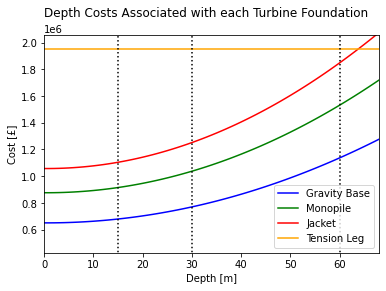

In [58]:
# Plots depth functions for each individual turbine foundation type

Depthx = range(0,math.ceil((max(data['CORR_DEPTH']))),1)
GBCost = [None] * len(Depthx)
MPCost = [None] * len(Depthx)
JCost = [None] * len(Depthx)
TLCost = [None] * len(Depthx)
Depth = 0

for i in Depthx:
    GBCost[i] = foundationDepthCost(GravityBase,Depth)
    MPCost[i] = foundationDepthCost(Monopile,Depth)
    JCost[i] = foundationDepthCost(Jacket,Depth)
    TLCost[i] = TensionLeg
    Depth += 1
    
fig, ax = plt.subplots()
fig.suptitle('Depth Costs Associated with each Turbine Foundation')

x1 = np.linspace(15,15,100)
x2 = np.linspace(30,30,100)
x3 = np.linspace(60,60,100)
y = np.linspace(0,TensionLeg+500000,100)

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH']-1)))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx,GBCost,'blue')
ax.plot(Depthx,MPCost,'green')
ax.plot(Depthx,JCost,'red')
ax.plot(Depthx,TLCost,'orange')
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')
plt.legend(['Gravity Base','Monopile','Jacket','Tension Leg'])

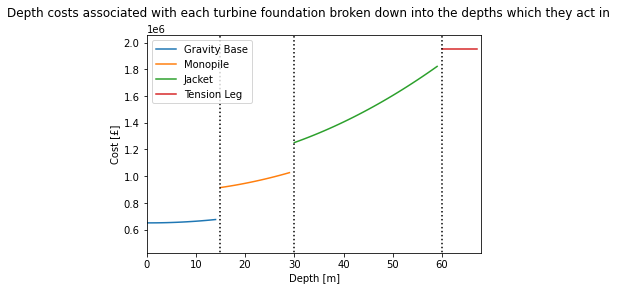

In [59]:
# Plots depth functions for each individual turbine foundation type but only considers the depths for which the foundation will act in

GBCost2 = GBCost[Depthx[0]:Depthx[15]]
MPCost2 = MPCost[Depthx[15]:Depthx[30]]
JCost2 = JCost[Depthx[30]:Depthx[60]]
TLCost2 = TLCost[Depthx[60]:max(Depthx)]

fig, ax = plt.subplots()
fig.suptitle('Depth costs associated with each turbine foundation broken down into the depths which they act in')

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH']-1)))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx[0:15],GBCost2)
ax.plot(Depthx[15:30],MPCost2)
ax.plot(Depthx[30:60],JCost2)
ax.plot(Depthx[60:max(Depthx)],TLCost2)
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')
plt.legend(['Gravity Base','Monopile','Jacket','Tension Leg'])

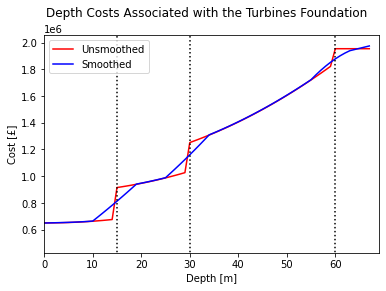

In [60]:
# Combines all the indivdual depths costs over there used depths into one plot and smooths the data

GBMPJTL = GBCost2+MPCost2+JCost2+TLCost2

fig, ax = plt.subplots()
fig.suptitle('Depth Costs Associated with the Turbines Foundation')

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH'])))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx[0:max(Depthx)],GBMPJTL,color='r')
smoothed_2dg = savgol_filter(GBMPJTL, window_length = 9, polyorder = 1)
ax.plot(Depthx[0:max(Depthx)], smoothed_2dg, color='b')
plt.legend(['Unsmoothed','Smoothed'])
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')

In [61]:
def foundations(positionlist):
    
    DepthPerTurbine = [None] * (len(positionlist)-1) # none defines a null/no value. Get a null list the size of the np. turbines
    FoundationCost = [None] * (len(positionlist)-1) # Get a null list the size of the number of turbines
    FoundationCostTotal = 0 # Assigns initial value to variable
    
    for i in range(0,len(positionlist)-1): # loops for amount of turbines
        DepthPerTurbine[i] = spline.SmoothBivariateSpline.ev(smooth, positionlist[i+1,0], positionlist[i+1,1])
        
        FoundationCost[i] = np.interp(DepthPerTurbine[i],Depthx[0:max(Depthx)],smoothed_2dg)

        FoundationCostTotal += FoundationCost[i]
        
    return FoundationCostTotal

FoundationCostTotal = foundations(positionlist)

In [62]:
# Function for calculated payback time, discounted payback time, Net Present Value, and Profitability Index

def Payback(TPO,TotalCost,positionlist):
    
    nturb=np.size(positionlist,0)-1 # -1 due to the substation at positonlist[0,:]
    
    CashFlowYearly = (ElectricityCostperkWh*24*365*(TPO/1000))-(OperatingandMaintenanceCostsperAnnum*nturb) # Calculates the yaerly cash flow for the windfarm
    PayBackTime = TotalCost/CashFlowYearly # calculates payback time in years
    DiscountedPayBackTime = (np.log(1/(1-((TotalCost*DiscountRate)/CashFlowYearly))))/np.log(1+DiscountRate) #Calculates payback time but takes into account the time value of money
    
    l=0
    NPV = 0
    
    for l in range(LifeTimeTurbineOperatingTime):
        l+=1
        NPV = NPV + (CashFlowYearly)/((1+DiscountRate)**l) #NPV is a method used to determine the current value of future cash flows generated by the project
    
    NPV = NPV - TotalCost
    ProfIndex = (NPV+TotalCost)/TotalCost # Probability index >1 it's profitable <1 its not
    
    return PayBackTime,DiscountedPayBackTime,NPV,ProfIndex

In [63]:
#PLOTTING FUNCTION

def plotting_function(positionlist,indiceslist,MSTweight,data,OnshoreSubstation,ExportDistance):
    
    mindepth = depthvalues(positionlist)[1]
    maxdepth = depthvalues(positionlist)[2]
    
    nturb=np.size(positionlist,0)-1 # -1 due to the substation ar positonlist[0,:]
    links = [None] * math.ceil(nturb/maxnodespertree) # math.ceil rounds a number upwards to its nearest integer
    MSTWeightSum = 0

    fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
    fig.suptitle('Plot Showing Sea Floor Topography and Turbines with Cables')
    
    #Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
    ax1.set_ylabel('y distance [m]') # y axis label
    ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
    ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 
    
    #Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
    ax2.set_xlabel('x distance [m]') # x axis label
    ax2.set_ylabel('y distance [m]') # y axis label
    ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
    ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits
    
    for a in range(0,len(MSTweight)):
        MSTWeightSum += MSTweight[a][0]
        links[a] = MSTweight[a][1]
        for b in links[a]:
            u = positionlist[(indiceslist[a,b[0]])][0], positionlist[(indiceslist[a,b[1]])][0]
            v = positionlist[(indiceslist[a,b[0]])][1], positionlist[(indiceslist[a,b[1]])][1]
            ax1.plot(u,v, c='black')
    
    FoundationCostTotal = foundations(positionlist)
    ExportCableCost = (ExportDistance*ExportCableCostperMeter) # Export cable cost
    FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*TurbineRating*nturb
    CableCost=(MSTWeightSum/1000)*IACableCostperMeter
    DepthCostAll = depthvalues(positionlist)[0]
    TurbineCostTotal =(nturb)*CostperTurbine
    MaintenanceCosts=(nturb)*MaintenanceCostperTurbine 
    LandCost = LandAreaCost(positionlist,ExportDistance)
    TotalCost=TurbineCostTotal+DepthCostAll+MaintenanceCosts+FixedCost+LandCost+CableCost+ExportCableCost+FoundationCostTotal 

    print('\033[1m'+'Maximum turbines per MST:'+'\033[0m', maximumturbinespertree)
    print('\033[1m'+'Number of turbines:'+'\033[0m', nturb)
    print()
    print('\033[1m'+'Inter-Array Cabling Costs: £'+'\033[0m', CableCost)
    print('\033[1m'+'Export Cabling Costs: £'+'\033[0m', ExportCableCost)
    print('\033[1m'+'Depth Cost: £'+'\033[0m', DepthCostAll)
    print('\033[1m'+'Foundations Cost: £'+'\033[0m', FoundationCostTotal)
    print('\033[1m'+'Turbine Cost: £'+'\033[0m', TurbineCostTotal)
    print('\033[1m'+'Land Cost: £'+'\033[0m', LandCost)
    print('\033[1m'+'Maintenance Cost: £'+'\033[0m', MaintenanceCosts)
    print('\033[1m'+'Fixed Cost:'+'\033[0m', FixedCost)
    print()
    print('\033[1m'+'Budget: £'+'\033[0m', budget)
    print('\033[1m'+'Total Cost: £'+'\033[0m', TotalCost)
        
    levels = np.linspace(mindepth-3,maxdepth+3,24) # Change to min(smooth) and max(smooth) somehow
    
    fig.subplots_adjust(left=0.1, right=0.8) #Adjusts plots to be able to fit a single color bar across both plots
    
    #Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
    tcf = ax1.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')
    cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8]) #Locates colorbar across both subplots
    cbar = plt.colorbar(tcf,cax=cb_ax) #plots colorbar with location as stated by cb_ax
    cbar.set_label('Depth (m)')    
    
    ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
    ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue') # offshore Substation
    ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
    
    #Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
    tcf = ax2.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')

    ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
    ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
    ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
    
    fig, ax3 = plt.subplots()
    PieChartLabels = ['(Inter-Array) Cabling Costs', 'Depth Costs', 'Turbine Costs', 'Land Costs', '(Life time) Maintenance Costs', 'Fixed Costs','(Export) Cabling Costs','Foundation Costs'] # Titles for each segment of pie chart
    sizes = [CableCost,DepthCostAll,TurbineCostTotal,LandCost,MaintenanceCosts,FixedCost,ExportCableCost,FoundationCostTotal] # Figures for each segment of pie chart
    
    ax3.pie(sizes, labels=PieChartLabels, autopct='%1.1f%%') # Pie chart with brekadown of all associated costs
    ax3.axis('equal') #equal aspect ratio
    ax3.set_title('Wind Farm Costs') #Pie chart title
                                                                                                  
    return TotalCost

 C:\Users\adamb\OneDrive - University of Warwick\University Documents\3rd Year\ES327 Individual Project\Wind-Farm-Layout-Gaussian-Optimisation\three_desc_model.py:335: RuntimeWarning:invalid value encountered in arccos
 C:\Users\adamb\anaconda3\lib\site-packages\numpy\lib\function_base.py:2197: RuntimeWarning:invalid value encountered in q (vectorized)


PRE-OPTIMISED LAYOUT INFORMATION
Maximum turbines per MST: 10
Number of turbines: 35

Inter-Array Cabling Costs: £ 4410423.9519081265
Export Cabling Costs: £ 10507878.151260504
Depth Cost: £ 5634628.501841279
Foundations Cost: £ 35490725.1491578
Turbine Cost: £ 77720207.253886
Land Cost: £ 4872222.4604062885
Maintenance Cost: £ 45850000.0
Fixed Cost: 11250000.0

Budget: £ 200000000.0
Total Cost: £ 195736085.46846
Total Power Output: 17408639.454946868 W
Theoretical Max Total Power Output: 26386276.442887373 W
Percentage power lost to wake effcts: 34.02388740742727 %
Cost per Watt: 11.243617628765314 £/W

Payback Time: 9.952283805282008 years
Discounted Payback Time: 17.63116137755874 years
NPV: £ 12621204.012562245 over a  20 year period
Profitability Index: £ 1.0644807214896304 over a  20 year period


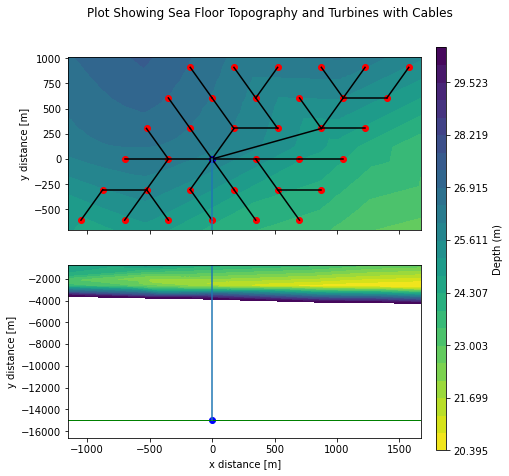

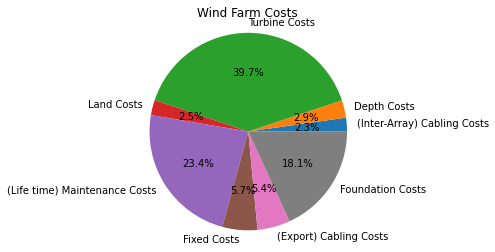

In [64]:
## PRE-OPTIMISED LAYOUT AND GAUSSIAN TESTING

# CALCULATES 
wsr=windspeedreduction(positionlist[1:,:],angles,predict_class)
powout=power(wsr,velocities) # total output power
output=np.tensordot(powout,wsp,axes=2)

## Below calculates max theoreticl power output
wsr_noWake = np.multiply(0.92477772, np.ones(wsr.shape))  ## 0.92477772 is not 1 because of the impact of the hub height
powout_noWake = power(wsr_noWake,velocities)
output_noWake=np.tensordot(powout_noWake,wsp,axes=2)
theoretical_max_power = np.sum(output_noWake)


#DISPLAYING PRE-OPTIMISED LAYOUT AND ASSOCIATED INFO

print('\033[1m'+'\033[4m'+'PRE-OPTIMISED LAYOUT INFORMATION'+'\033[0m'+'\033[0m')
MSTweight = Minimum_Spanning_Tree(distance,indiceslist)
TotalCost = plotting_function(positionlist,indiceslist,MSTweight,data,OnshoreSubstation,ExportDistance)

PayBackTime,DiscountedPayBackTime,NPV,ProfIndex = Payback((np.sum(output)),TotalCost,positionlist)

print('\033[1m'+'Total Power Output:'+'\033[0m', np.sum(output), 'W')
print('\033[1m'+'Theoretical Max Total Power Output:'+'\033[0m', theoretical_max_power, 'W')
print('\033[1m'+'Percentage power lost to wake effcts:'+'\033[0m', (1-(np.sum(output)/theoretical_max_power))*100, '%')
print('\033[1m'+'Cost per Watt:'+'\033[0m',TotalCost/np.sum(output),'£/W')
print('')
print('\033[1m'+'Payback Time:'+'\033[0m',PayBackTime,'years')
print('\033[1m'+'Discounted Payback Time:'+'\033[0m',DiscountedPayBackTime,'years')
print('\033[1m'+'NPV: £'+'\033[0m',NPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
print('\033[1m'+'Profitability Index: £'+'\033[0m',ProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

In [65]:
#REDUCING NO. OF TURBINES PRE-OPTIMISATION

overspend = TotalCost - budget
if overspend > 0:
    nturbstoremove = math.floor(overspend/(MinCostperTurbTot))
    ### It can be safely assumed that this many turbines at minimum can be removed.
    print('Number of removed turbines:', nturbstoremove)
    for amount in range(0,nturbstoremove):
        nturb = nturb - 1
        positionlist = np.delete(positionlist, len(positionlist)-1, 0)
    indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree)
    print('new number of turbines:', nturb)

In [66]:
v=2
for amount in range(0,v):
    nturb = nturb - 1
    positionlist = np.delete(positionlist, len(positionlist)-1, 0)
indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree)

 C:\Users\adamb\anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning:Spaces are not permitted in the name. Converted to '_'


In [67]:
#TARGET FUNCTION

# analyses the coordinates to collate the distances and angles between all of them
# calculates the minimum spanning tree length and adds the assumption of cabling costs,
# turbines costs, maintenance costs and fixed costs.

smallestindiceslist = []
smallestTotalCost = None
smallestCostPerWatt = 10000000000000.0
smallestpositionlist = []
smallestExportDistance = None

def targetfunction(coord_flat):
    
    #Global variables are used instead of res.x as res.x only holds the coordinates, not the other associated parameters,
    #inc. the optimal clustering, which will not necessarily be the same if the clustering algorithm is run again as the
    #start position is random for clustering. Additionally, res.x only provides an approximate minimization, whereas
    #storing values as global variables and finding the minimum guarantees that the minimum value found is returned.
    
    global smallestindiceslist
    global smallestTotalCost
    global smallestCostPerWatt
    global smallestpositionlist
    global smallestExportDistance

    arr2=np.reshape(coord_flat,(-1,2)) # undoes the coordinate flattening
    hull = ConvexHull(arr2)
    arr1 = np.array([np.mean(hull.points[hull.vertices,0]),np.mean(hull.points[hull.vertices,1])])
    arr1 = np.reshape(arr1,(-1,2))
    positionlist = np.concatenate((arr1,arr2),axis=0)
    #positionlist = np.reshape(coord_flat,(-1,2))#np.concatenate((arr1,arr2),axis=0) #np.reshape(coord_flat,(-1,2))
    
    nturb=np.size(positionlist,0)-1 # determines number of turbines (-1 due to the substation)
    print('nturb', nturb)
    
    OnshoreSubstation,ExportDistance = Substation_To_Shore_Connection(positionlist)

    indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree) # calls clustering function
    distance,angle,distance_global,angle_global = geom_analysis(positionlist,indiceslist) # calls pre-MST function
    
    MSTweight=Minimum_Spanning_Tree(distance,indiceslist) # Calls MST function
    MSTWeightSum=0
    
    for a in range(0,math.ceil(nturb/maxnodespertree)): 
        MSTWeightSum += MSTweight[a][0] 
#     wsr=windspeedreduction(distance_global,angle_global,angles,model) ## old WSR function
    wsr=windspeedreduction(positionlist[1:,:],angles,predict_class) ## new WSR function ## the "turbine" at origin is substantion and hence removed
    powout=power(wsr,velocities) # total output power
    output=np.tensordot(powout,wsp,axes=2) # reduced power output due to wake effects
    
    FoundationCostTotal = foundations(positionlist)
    ExportCableCost = (ExportDistance*ExportCableCostperMeter) # Export cable cost
    FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*TurbineRating*nturb
    CableCost= (MSTWeightSum/1000)*IACableCostperMeter
    DepthCostAll = depthvalues(positionlist)[0]
    TurbineCostTotal= (nturb)*CostperTurbine
    MaintenanceCosts= (nturb)*MaintenanceCostperTurbine
    LandCost = LandAreaCost(positionlist,ExportDistance)
    TotalCost= TurbineCostTotal+DepthCostAll+MaintenanceCosts+FixedCost+LandCost+CableCost+ExportCableCost+FoundationCostTotal

    print('Total power output in Watts', np.sum(output),'Total Cost in £', TotalCost, '£/W', (TotalCost/(np.sum(output))))###

    CostperWatt = TotalCost/(np.sum(output))
    
    if CostperWatt < smallestCostPerWatt:
        smallestCostPerWatt = CostperWatt
        smallestindiceslist = indiceslist
        smallestTotalCost = TotalCost
        smallestpositionlist = positionlist
        smallestExportDistance = ExportDistance

    print('smallest cost per watt',smallestCostPerWatt)
    
    return CostperWatt

In [68]:
angles

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [120]:
# OPTIMIZATION

#xright = 0
#xleft = 0
#yup = 0
#ydown = 0
#for xright in range(0,nturb+1):
 #   if positionlist[xright,0]>0:
  #      positionlist[xright,0] = positionlist[xright,0] + 250
#for xleft in range(0,nturb+1):
 #   if positionlist[xleft,0]<0:
  #      positionlist[xleft,0] = positionlist[xleft,0] - 250
#for yup in range(0,nturb+1):
 #   if positionlist[yup,1]>0:
  #      positionlist[yup,1] = positionlist[yup,1] + 250
#for ydown in range(0,nturb+1):
 #   if positionlist[ydown,1]<0:
  #      positionlist[ydown,1] = positionlist[ydown,1] - 250
        
        
t1_start = perf_counter() # timer starts

dvel=1.5
dang=1
velocities=np.arange(Vc,Vf,dvel)
angles=np.arange(0,360,dang)        
wsp=windspeedprobability(angles,velocities,dang,dvel) # tells probability of getting wind from a certain direction with a certain velocity.

while True:  
    
    iteration_time_start = perf_counter()
    
    #flat_coords=positionlist.flatten() # turns 2D coords into single list of data without any more structure.
    flat_coords=positionlist[1:,:].flatten() # turns 2D coords into single list of data without any more structure.
        
    # b = (Lower bound, Upper bound)
    b2 = ((min(positionlist[:,0]))-1000,(max(positionlist[:,0]))+1000) #bounds for x coordinates
    #b3 = ((OnshoreSubstation[1]+((TooCloseShore-2500))),(max(positionlist[:,1]))+1000) #bounds for y coordinates of turbines
    b3 = (((min(positionlist[:,1]))-1000),(max(positionlist[:,1]))+1000) #bounds for y coordinates of turbines
    bnd = (b2,b3) #bounds for x,y coordinates of each turbine 
    bnd1 = (bnd*(nturb)) #repeats bnd for the amount of turbines 
    bnds = bnd1 #Combines all bounds into a list for use in the optimization function
    
    #res = minimize(targetfunction, flat_coords, method='L-BFGS-B', jac=False, bounds=bnds, options={'disp': 2, 'eps': 50, 'ftol': 1e-17, 'gtol': 1e-17})
    res = minimize(targetfunction, flat_coords, method='L-BFGS-B', jac=False, options={'disp': 2, 'eps': 50})#, 'ftol': 1e-17, 'gtol': 1e-17})

    #res = minimize(targetfunction, flat_coords, method='Nelder-Mead', jac=False, bounds=bnds, options={'disp': 2, 'xatol': 1e-3, 'fatol': 1e-3})#, 'ftol': 1e-17, 'gtol': 1e-17})
    #res = minimize(targetfunction, flat_coords, method='TNC', jac=False, bounds=bnds, options={'disp': 2, 'eps':50})#, 'ftol': 1e-17, 'gtol': 1e-17})
    
    iteration_time_end = perf_counter()
    print(iteration_time_end-iteration_time_start)
    
    if smallestTotalCost<=budget: #if under budget
        if not res.success:
            print(res.status, res.message) 
        else:
            break # Stops optimization when minimization is under budget after an iteration of 'minimize' 
    else: # over budget then removes a turbine and resets approrate varaibles 
        nturb = nturb - 1 
        smallestindiceslist = []
        smallestTotalCost = None
        smallestCostPerWatt = 10000000000000.0
        smallestpositionlist = []
        smallestExportDistance = None
        
        wsr=windspeedreduction(positionlist[1:,:],angles,predict_class) ## new WSR function ## the "turbine" at origin is substantion and hence removed
        powout=power(wsr,velocities) # total output power
        outputs=np.tensordot(powout,wsp,axes=2)
        LowestPower = min(outputs)
        LowestPowerIndex = np.argmin(outputs)
        LowestPowerTurbine = positionlist[LowestPowerIndex+1,:]
        positionlist = np.delete(positionlist, LowestPowerIndex+1, 0) 

        # CANNOT USE CALLBACK as this only returns targetfunction output and not the other variables that are needed too.
          
t1_stop = perf_counter() # timer ends
totaltime = t1_stop - t1_start # total run time in seconds
print('Total function time:', totaltime)

nturb 33


 C:\Users\adamb\OneDrive - University of Warwick\University Documents\3rd Year\ES327 Individual Project\Wind-Farm-Layout-Gaussian-Optimisation\three_desc_model.py:335: RuntimeWarning:invalid value encountered in arccos
 C:\Users\adamb\anaconda3\lib\site-packages\numpy\lib\function_base.py:2197: RuntimeWarning:invalid value encountered in q (vectorized)


Total power output in Watts 16722428.097577484 Total Cost in £ 184986621.09898934 £/W 11.062186664494474
smallest cost per watt 11.062186664494474
nturb 33
Total power output in Watts 16742777.382221267 Total Cost in £ 185068410.96730796 £/W 11.05362669181921
smallest cost per watt 11.05362669181921
nturb 33
Total power output in Watts 16774235.640720326 Total Cost in £ 185081972.46069387 £/W 11.033705286182924
smallest cost per watt 11.033705286182924
nturb 33
Total power output in Watts 16752328.247627465 Total Cost in £ 185108477.01550338 £/W 11.049716450113088
smallest cost per watt 11.033705286182924
nturb 33
Total power output in Watts 16777718.707373086 Total Cost in £ 185029692.9579139 £/W 11.028298673084876
smallest cost per watt 11.028298673084876
nturb 33
Total power output in Watts 16773839.8914072 Total Cost in £ 185066758.20837066 £/W 11.033058584467325
smallest cost per watt 11.028298673084876
nturb 33
Total power output in Watts 16792507.045711692 Total Cost in £ 185090

Total power output in Watts 16762561.053897867 Total Cost in £ 185140946.0608467 £/W 11.044908082097342
smallest cost per watt 11.021470383561272
nturb 33
Total power output in Watts 16761833.995123524 Total Cost in £ 185065841.0294604 £/W 11.04090644754632
smallest cost per watt 11.021470383561272
nturb 33
Total power output in Watts 16759980.747372938 Total Cost in £ 185173314.49509925 £/W 11.048539809577314
smallest cost per watt 11.021470383561272
nturb 33
Total power output in Watts 16756130.744944446 Total Cost in £ 185065962.58608878 £/W 11.044671672899527
smallest cost per watt 11.021470383561272
nturb 33
Total power output in Watts 16767885.082419634 Total Cost in £ 185210825.80307567 £/W 11.045568650590337
smallest cost per watt 11.021470383561272
nturb 33
Total power output in Watts 16776974.139958395 Total Cost in £ 185001850.77073035 £/W 11.027128564864626
smallest cost per watt 11.021470383561272
nturb 33
Total power output in Watts 16774970.631187454 Total Cost in £ 1851

Total power output in Watts 17549613.62191942 Total Cost in £ 184960253.6214436 £/W 10.539277821503076
smallest cost per watt 10.512124416793826
nturb 33
Total power output in Watts 17551950.025080647 Total Cost in £ 184952320.5043922 £/W 10.537422921106021
smallest cost per watt 10.512124416793826
nturb 33
Total power output in Watts 17563799.52547048 Total Cost in £ 184932284.2693091 £/W 10.529173030079626
smallest cost per watt 10.512124416793826
nturb 33
Total power output in Watts 17533827.573750064 Total Cost in £ 184958155.98374006 £/W 10.548646905861066
smallest cost per watt 10.512124416793826
nturb 33
Total power output in Watts 17566860.0045377 Total Cost in £ 184933053.61632815 £/W 10.527382444475451
smallest cost per watt 10.512124416793826
nturb 33
Total power output in Watts 17540008.11253985 Total Cost in £ 184937572.19851142 £/W 10.543756366127008
smallest cost per watt 10.512124416793826
nturb 33
Total power output in Watts 17568540.936139777 Total Cost in £ 184933485

Total power output in Watts 17551728.757989373 Total Cost in £ 184965583.61052215 £/W 10.538311419969252
smallest cost per watt 10.512124416793826
nturb 33
Total power output in Watts 17571032.93512119 Total Cost in £ 184978779.28970847 £/W 10.527484637512156
smallest cost per watt 10.512124416793826
nturb 33
Total power output in Watts 17569287.15492232 Total Cost in £ 184983372.27454257 £/W 10.528792127045204
smallest cost per watt 10.512124416793826
nturb 33
Total power output in Watts 17583588.750032004 Total Cost in £ 184946964.706729 £/W 10.518158001528121
smallest cost per watt 10.512124416793826
nturb 33
Total power output in Watts 17565362.36228203 Total Cost in £ 184974954.91937166 £/W 10.530665471300892
smallest cost per watt 10.512124416793826
nturb 33
Total power output in Watts 17595998.628395814 Total Cost in £ 185007301.4230225 £/W 10.514168893174617
smallest cost per watt 10.512124416793826
nturb 33
Total power output in Watts 17564191.563147344 Total Cost in £ 1850016

Total power output in Watts 17545886.20825228 Total Cost in £ 184926827.01184946 £/W 10.539611668339306
smallest cost per watt 10.512124416793826
nturb 33
Total power output in Watts 17543304.630320836 Total Cost in £ 184936476.02072477 £/W 10.541712631558095
smallest cost per watt 10.512124416793826
nturb 33
Total power output in Watts 17568450.539969217 Total Cost in £ 184937333.1309469 £/W 10.52667295332642
smallest cost per watt 10.512124416793826
nturb 33
Total power output in Watts 17560871.36833423 Total Cost in £ 185008391.3494923 £/W 10.535262599958424
smallest cost per watt 10.512124416793826
nturb 33
Total power output in Watts 17576668.240799896 Total Cost in £ 184936460.73491707 £/W 10.521701735578802
smallest cost per watt 10.512124416793826
nturb 33
Total power output in Watts 17578860.342411075 Total Cost in £ 184976385.17456913 £/W 10.52266083076454
smallest cost per watt 10.512124416793826
nturb 33
Total power output in Watts 17573585.635113653 Total Cost in £ 1849256

Total power output in Watts 17567579.617833238 Total Cost in £ 184917352.3312458 £/W 10.526057450938325
smallest cost per watt 10.51211394261544
nturb 33
Total power output in Watts 17599011.76693848 Total Cost in £ 185054522.58181092 £/W 10.515051926350461
smallest cost per watt 10.51211394261544
nturb 33
Total power output in Watts 17581017.91613655 Total Cost in £ 185001626.63394314 £/W 10.522805193443398
smallest cost per watt 10.51211394261544
nturb 33
Total power output in Watts 17554815.7271615 Total Cost in £ 184982529.50808823 £/W 10.537423598350623
smallest cost per watt 10.51211394261544
nturb 33
Total power output in Watts 17564139.516825166 Total Cost in £ 184969079.53998554 £/W 10.531064124308433
smallest cost per watt 10.51211394261544
nturb 33
Total power output in Watts 17568329.945983544 Total Cost in £ 185006889.09577107 £/W 10.530704379107314
smallest cost per watt 10.51211394261544
nturb 33
Total power output in Watts 17569051.010190107 Total Cost in £ 184898570.42

Total power output in Watts 17542872.27758936 Total Cost in £ 185147486.1866613 £/W 10.554000693671084
smallest cost per watt 10.51211394261544
nturb 33
Total power output in Watts 17584093.468356952 Total Cost in £ 185064357.74257103 £/W 10.524532190163757
smallest cost per watt 10.51211394261544
nturb 33
Total power output in Watts 17562772.810683444 Total Cost in £ 184976125.02480385 £/W 10.532284794590224
smallest cost per watt 10.51211394261544
nturb 33
Total power output in Watts 17587333.92373743 Total Cost in £ 185178698.65936482 £/W 10.529094373390567
smallest cost per watt 10.51211394261544
nturb 33
Total power output in Watts 17559048.28194571 Total Cost in £ 184976333.02073747 £/W 10.534530690420787
smallest cost per watt 10.51211394261544
nturb 33
Total power output in Watts 17591419.049974177 Total Cost in £ 185091817.05623123 £/W 10.521710416335226
smallest cost per watt 10.51211394261544
nturb 33
Total power output in Watts 17574161.98036209 Total Cost in £ 184979497.74

Total power output in Watts 17549640.016267892 Total Cost in £ 184960351.68354958 £/W 10.539267558314467
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17551976.77100151 Total Cost in £ 184932857.9305752 £/W 10.536298010382051
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17563826.576367635 Total Cost in £ 184932256.46117324 £/W 10.529155230330165
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17533856.1288914 Total Cost in £ 184855386.60087138 £/W 10.542768529751767
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17566887.126530185 Total Cost in £ 184933092.49090302 £/W 10.5273684039109
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17540034.55800775 Total Cost in £ 184937594.39393246 £/W 10.543741734505351
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17568568.802363332 Total Cost in £ 18493355

Total power output in Watts 17560007.640423145 Total Cost in £ 184965217.85096684 £/W 10.533322173800018
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17570755.30181509 Total Cost in £ 184978435.24067014 £/W 10.527631400202901
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17569014.518021062 Total Cost in £ 185007822.70028988 £/W 10.530347192241308
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17583318.190413844 Total Cost in £ 184993406.65182424 £/W 10.52096109781371
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17565092.34977388 Total Cost in £ 184974720.4649224 £/W 10.530814002085428
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17595731.98310093 Total Cost in £ 185123593.55299488 £/W 10.520937334734864
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17563920.895417456 Total Cost in £ 185001

Total power output in Watts 17534035.919162773 Total Cost in £ 185014839.88815504 £/W 10.551754355992516
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17531454.46232421 Total Cost in £ 184936491.2024939 £/W 10.548839036711401
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17556600.164345 Total Cost in £ 184937267.83112508 £/W 10.533774540625856
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17549020.515326936 Total Cost in £ 184940947.99453852 £/W 10.538533921765895
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17565172.900738094 Total Cost in £ 184952722.63778585 £/W 10.529513354805296
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17566992.25284697 Total Cost in £ 184949717.50714183 £/W 10.528251782952099
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17573596.441955198 Total Cost in £ 1849256

Total power output in Watts 17578923.480859138 Total Cost in £ 185061767.54797792 £/W 10.52748012410902
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17567590.47659273 Total Cost in £ 184917341.61428878 £/W 10.52605033460194
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17599022.626260065 Total Cost in £ 185054534.66078874 £/W 10.515046124474148
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17580706.529826537 Total Cost in £ 184960689.565156 £/W 10.520663049085147
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17554510.415310107 Total Cost in £ 184978792.66157818 £/W 10.537393996488193
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17563824.31581858 Total Cost in £ 184970876.06055057 £/W 10.531355400427199
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17568015.54683434 Total Cost in £ 18496587

Total power output in Watts 17539253.78016513 Total Cost in £ 184916622.89171124 £/W 10.543015410429296
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17582022.232236814 Total Cost in £ 185013193.24611518 £/W 10.522861978122837
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17542541.957306873 Total Cost in £ 185018580.04091993 £/W 10.546851219806
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17583772.58726284 Total Cost in £ 185047695.1834908 £/W 10.523776639236898
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17562463.444826283 Total Cost in £ 184965476.66897288 £/W 10.531864009286338
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17587021.706681862 Total Cost in £ 185051397.89128646 £/W 10.522042957448539
smallest cost per watt 10.512112374391412
nturb 33
Total power output in Watts 17558732.116220392 Total Cost in £ 1849353

Total power output in Watts 17576347.30772555 Total Cost in £ 184984296.88636267 £/W 10.524615475995644
smallest cost per watt 10.508524180556753
nturb 33
Total power output in Watts 17544702.626655005 Total Cost in £ 184928557.71222475 £/W 10.540421325310454
smallest cost per watt 10.508524180556753
nturb 33
Total power output in Watts 17570462.874327686 Total Cost in £ 184970026.6251824 £/W 10.527328047540697
smallest cost per watt 10.508524180556753
nturb 33
Total power output in Watts 17549640.016267892 Total Cost in £ 184960351.68354958 £/W 10.539267558314467
smallest cost per watt 10.508524180556753
nturb 33
Total power output in Watts 17551976.77100151 Total Cost in £ 184932781.47319275 £/W 10.536293654326695
smallest cost per watt 10.508524180556753
nturb 33
Total power output in Watts 17563826.576367635 Total Cost in £ 184932256.46117324 £/W 10.529155230330165
smallest cost per watt 10.508524180556753
nturb 33
Total power output in Watts 17533856.1288914 Total Cost in £ 185046

Total power output in Watts 17563347.736118376 Total Cost in £ 184937725.46177986 £/W 10.52975368024299
smallest cost per watt 10.508524180556753
nturb 33
Total power output in Watts 17576874.160569526 Total Cost in £ 184915887.6168513 £/W 10.520408004722249
smallest cost per watt 10.508524180556753
nturb 33
Total power output in Watts 17576351.05835791 Total Cost in £ 184929752.33259344 £/W 10.5215099379035
smallest cost per watt 10.508524180556753
nturb 33
Total power output in Watts 17564895.76245122 Total Cost in £ 184915569.21142185 £/W 10.52756428004082
smallest cost per watt 10.508524180556753
nturb 33
Total power output in Watts 17575618.279111672 Total Cost in £ 184982887.16336012 £/W 10.524971823222241
smallest cost per watt 10.508524180556753
nturb 33
Total power output in Watts 17573753.18747896 Total Cost in £ 184885026.66377637 £/W 10.520520271987445
smallest cost per watt 10.508524180556753
nturb 33
Total power output in Watts 17588037.411979165 Total Cost in £ 184999374

Total power output in Watts 17593563.58679966 Total Cost in £ 184951755.68414536 £/W 10.512466946884684
smallest cost per watt 10.504386107424708
nturb 33
Total power output in Watts 17585013.755249478 Total Cost in £ 184966066.3114084 £/W 10.5183919037989
smallest cost per watt 10.504386107424708
nturb 33
Total power output in Watts 17601360.91973599 Total Cost in £ 184950828.52839068 £/W 10.507757290574599
smallest cost per watt 10.504386107424708
nturb 33
Total power output in Watts 17571236.121161986 Total Cost in £ 184941145.90820074 £/W 10.525221141696807
smallest cost per watt 10.504386107424708
nturb 33
Total power output in Watts 17569054.2415268 Total Cost in £ 184966280.1184173 £/W 10.527958851719225
smallest cost per watt 10.504386107424708
nturb 33
Total power output in Watts 17593502.475871094 Total Cost in £ 185054036.52696842 £/W 10.518317019636306
smallest cost per watt 10.504386107424708
nturb 33
Total power output in Watts 17584929.6837769 Total Cost in £ 184955931.5

Total power output in Watts 17613983.315917715 Total Cost in £ 185211736.28243786 £/W 10.515039838550457
smallest cost per watt 10.499212859651657
nturb 33
Total power output in Watts 17613598.73505788 Total Cost in £ 185062233.19287768 £/W 10.50678149176478
smallest cost per watt 10.499212859651657
nturb 33
Total power output in Watts 17595420.08586462 Total Cost in £ 185085007.9336256 £/W 10.5189308939725
smallest cost per watt 10.499212859651657
nturb 33
Total power output in Watts 17615137.096867 Total Cost in £ 185073151.35150808 £/W 10.506483732359081
smallest cost per watt 10.499212859651657
nturb 33
Total power output in Watts 17591502.38593357 Total Cost in £ 184971212.17556298 £/W 10.514804711817494
smallest cost per watt 10.499212859651657
nturb 33
Total power output in Watts 17623019.06244894 Total Cost in £ 185068757.80452377 £/W 10.501535358312557
smallest cost per watt 10.499212859651657
nturb 33
Total power output in Watts 17973909.397446092 Total Cost in £ 185395241.12

Total power output in Watts 17941118.075070865 Total Cost in £ 185405096.23585254 £/W 10.334088180015515
smallest cost per watt 10.307882835919077
nturb 33
Total power output in Watts 17986459.13931966 Total Cost in £ 185561196.4296895 £/W 10.316716313776276
smallest cost per watt 10.307882835919077
nturb 33
Total power output in Watts 17925356.935600445 Total Cost in £ 185383108.94581336 £/W 10.341947979715561
smallest cost per watt 10.307882835919077
nturb 33
Total power output in Watts 17978112.902420145 Total Cost in £ 185470773.6489189 £/W 10.316476187217154
smallest cost per watt 10.307882835919077
nturb 33
Total power output in Watts 17957758.366566792 Total Cost in £ 185415764.88549152 £/W 10.325106346830735
smallest cost per watt 10.307882835919077
nturb 33
Total power output in Watts 17991915.285313763 Total Cost in £ 185715853.77348965 £/W 10.322183649068407
smallest cost per watt 10.307882835919077
nturb 33
Total power output in Watts 17953123.943171248 Total Cost in £ 1852

Total power output in Watts 19627877.99835852 Total Cost in £ 189561924.8795792 £/W 9.657790052263023
smallest cost per watt 9.651972094908807
nturb 33
Total power output in Watts 19612872.570336368 Total Cost in £ 189610630.21640986 £/W 9.667662375127438
smallest cost per watt 9.651972094908807
nturb 33
Total power output in Watts 19609537.715471964 Total Cost in £ 189400165.60185692 £/W 9.658573718054546
smallest cost per watt 9.651972094908807
nturb 33
Total power output in Watts 19621459.215260386 Total Cost in £ 189647771.63240823 £/W 9.665324558782643
smallest cost per watt 9.651972094908807
nturb 33
Total power output in Watts 19607202.085101552 Total Cost in £ 189688410.76110673 £/W 9.67442524118424
smallest cost per watt 9.651972094908807
nturb 33
Total power output in Watts 19608326.265953403 Total Cost in £ 189651711.4952831 £/W 9.67199897242539
smallest cost per watt 9.651972094908807
nturb 33
Total power output in Watts 19600772.8679882 Total Cost in £ 189763469.84945604 £

Total power output in Watts 19933598.02577719 Total Cost in £ 192824760.43706676 £/W 9.6733545137067
smallest cost per watt 9.651972094908807
nturb 33
Total power output in Watts 19934270.51825376 Total Cost in £ 193153265.83997077 £/W 9.68950760766996
smallest cost per watt 9.651972094908807
nturb 33
Total power output in Watts 19946548.592005588 Total Cost in £ 193129580.39848706 £/W 9.682355797428123
smallest cost per watt 9.651972094908807
nturb 33
Total power output in Watts 19926552.55844288 Total Cost in £ 193020947.40628046 £/W 9.686620244026983
smallest cost per watt 9.651972094908807
nturb 33
Total power output in Watts 19942339.951025695 Total Cost in £ 192870764.26604182 £/W 9.671420943564945
smallest cost per watt 9.651972094908807
nturb 33
Total power output in Watts 19943591.74538292 Total Cost in £ 193048228.61312503 £/W 9.679712214216229
smallest cost per watt 9.651972094908807
nturb 33
Total power output in Watts 19945671.98463493 Total Cost in £ 192848762.67222258 £/

Total power output in Watts 19819985.102845337 Total Cost in £ 189908003.7265119 £/W 9.581642102205661
smallest cost per watt 9.568749587521083
nturb 33
Total power output in Watts 19817706.40841841 Total Cost in £ 190019461.00035983 £/W 9.588367951582986
smallest cost per watt 9.568749587521083
nturb 33
Total power output in Watts 19826007.810326442 Total Cost in £ 189995627.99523652 £/W 9.583151071708782
smallest cost per watt 9.568749587521083
nturb 33
Total power output in Watts 19816719.805866204 Total Cost in £ 190206211.80046573 £/W 9.598269222344271
smallest cost per watt 9.568749587521083
nturb 33
Total power output in Watts 19826956.143849034 Total Cost in £ 189970985.65205395 £/W 9.581449833941814
smallest cost per watt 9.568749587521083
nturb 33
Total power output in Watts 19812564.481986564 Total Cost in £ 189969296.19702598 £/W 9.58832443774478
smallest cost per watt 9.568749587521083
nturb 33
Total power output in Watts 19807720.68287919 Total Cost in £ 190050909.3796863

Total power output in Watts 19829816.800358534 Total Cost in £ 189962007.38094288 £/W 9.579614844324142
smallest cost per watt 9.568749587521083
nturb 33
Total power output in Watts 19836603.18358238 Total Cost in £ 190075423.1234677 £/W 9.5820550204272
smallest cost per watt 9.568749587521083
nturb 33
Total power output in Watts 19818509.2589876 Total Cost in £ 189697997.89124638 £/W 9.571759177861434
smallest cost per watt 9.568749587521083
nturb 33
Total power output in Watts 19810983.159763616 Total Cost in £ 189971535.73421666 £/W 9.589202827654283
smallest cost per watt 9.568749587521083
nturb 33
Total power output in Watts 19703051.11190115 Total Cost in £ 189723948.63105226 £/W 9.629165937475243
smallest cost per watt 9.568749587521083
nturb 33
Total power output in Watts 19692330.756057967 Total Cost in £ 189765887.90768886 £/W 9.63653770894088
smallest cost per watt 9.568749587521083
nturb 33
Total power output in Watts 19699569.47038771 Total Cost in £ 189588250.70894632 £/W

Total power output in Watts 19680967.709636755 Total Cost in £ 189545669.7580617 £/W 9.630912084940364
smallest cost per watt 9.568749587521083
nturb 33
Total power output in Watts 19707701.803947743 Total Cost in £ 189691999.5829623 £/W 9.625272468094895
smallest cost per watt 9.568749587521083
nturb 33
Total power output in Watts 19698819.997176412 Total Cost in £ 189812818.73426735 £/W 9.635745631539084
smallest cost per watt 9.568749587521083
nturb 33
Total power output in Watts 19676077.020039983 Total Cost in £ 189625121.68302563 £/W 9.637343942590457
smallest cost per watt 9.568749587521083
nturb 33
Total power output in Watts 19707261.081585567 Total Cost in £ 189733948.13854408 £/W 9.627616306145717
smallest cost per watt 9.568749587521083
nturb 33
Total power output in Watts 19708174.37150025 Total Cost in £ 189862431.96525443 £/W 9.633689472517158
smallest cost per watt 9.568749587521083
nturb 33
Total power output in Watts 19699390.734764863 Total Cost in £ 189634164.964598

Total power output in Watts 19821688.77458673 Total Cost in £ 189980256.94627967 £/W 9.584463720863797
smallest cost per watt 9.566741116387705
nturb 33
Total power output in Watts 19832611.32950731 Total Cost in £ 190345192.9090001 £/W 9.597586003503288
smallest cost per watt 9.566741116387705
nturb 33
Total power output in Watts 19831649.08537957 Total Cost in £ 189958899.19386175 £/W 9.578573036263768
smallest cost per watt 9.566741116387705
nturb 33
Total power output in Watts 19826623.981948018 Total Cost in £ 190036174.40479234 £/W 9.58489829523265
smallest cost per watt 9.566741116387705
nturb 33
Total power output in Watts 19827468.850332424 Total Cost in £ 189973081.98360202 £/W 9.581307801697388
smallest cost per watt 9.566741116387705
nturb 33
Total power output in Watts 19818012.296954885 Total Cost in £ 189883780.27261782 £/W 9.581373622509771
smallest cost per watt 9.566741116387705
nturb 33
Total power output in Watts 19834877.57458662 Total Cost in £ 190099188.5564406 £

Total power output in Watts 20153424.33506488 Total Cost in £ 192484986.721697 £/W 9.550981685370113
smallest cost per watt 9.53683313192152
nturb 33
Total power output in Watts 20149322.946924053 Total Cost in £ 192584179.67938003 £/W 9.557848677430597
smallest cost per watt 9.53683313192152
nturb 33
Total power output in Watts 20149014.877654534 Total Cost in £ 192489835.29906103 £/W 9.553312480429714
smallest cost per watt 9.53683313192152
nturb 33
Total power output in Watts 20143240.99035109 Total Cost in £ 192561425.49877882 £/W 9.559604911196693
smallest cost per watt 9.53683313192152
nturb 33
Total power output in Watts 20139428.384283476 Total Cost in £ 192377009.55336335 £/W 9.552257684904882
smallest cost per watt 9.53683313192152
nturb 33
Total power output in Watts 20144522.41820773 Total Cost in £ 192167807.58214366 £/W 9.539457108620843
smallest cost per watt 9.53683313192152
nturb 33
Total power output in Watts 20142685.602919064 Total Cost in £ 192364341.3604111 £/W 9.

Total power output in Watts 20012200.294769503 Total Cost in £ 190746522.56209838 £/W 9.531511765448046
smallest cost per watt 9.5200206599048
nturb 33
Total power output in Watts 20005100.275553808 Total Cost in £ 190876016.3530236 £/W 9.54136763744562
smallest cost per watt 9.5200206599048
nturb 33
Total power output in Watts 20000293.950591967 Total Cost in £ 190940910.8147633 £/W 9.54690522481605
smallest cost per watt 9.5200206599048
nturb 33
Total power output in Watts 20018312.828009523 Total Cost in £ 190892404.76178125 £/W 9.535888783528527
smallest cost per watt 9.5200206599048
nturb 33
Total power output in Watts 19990019.78244978 Total Cost in £ 190622812.7648788 £/W 9.535899155649458
smallest cost per watt 9.5200206599048
nturb 33
Total power output in Watts 19997555.857990075 Total Cost in £ 190579124.94824207 £/W 9.530120895854164
smallest cost per watt 9.5200206599048
nturb 33
Total power output in Watts 19995830.231273547 Total Cost in £ 190854338.756082 £/W 9.54470689

Total power output in Watts 20002403.56674968 Total Cost in £ 190967126.27011827 £/W 9.547208945807194
smallest cost per watt 9.5200206599048
nturb 33
Total power output in Watts 20116397.140836142 Total Cost in £ 191214010.37727997 £/W 9.50538056286018
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20110764.000992242 Total Cost in £ 191385921.84852555 £/W 9.516591305983342
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20110079.571161646 Total Cost in £ 191407164.24421722 £/W 9.517971501152081
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20114328.857835617 Total Cost in £ 191563305.76111147 £/W 9.523723466740837
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20105648.967285126 Total Cost in £ 191423835.06635094 £/W 9.520898100719151
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20122829.14270898 Total Cost in £ 191465857.97726122 £/W 

Total power output in Watts 20116679.79766163 Total Cost in £ 191394667.4505595 £/W 9.514227465747469
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20108065.47292766 Total Cost in £ 191445604.27726114 £/W 9.52083652875571
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20112141.89228871 Total Cost in £ 191646647.08462825 £/W 9.528902894132244
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20109062.496196702 Total Cost in £ 191554220.87880015 £/W 9.525765853829808
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20115042.72831826 Total Cost in £ 191616714.8822331 £/W 9.526040658739054
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20118153.06767244 Total Cost in £ 191424819.5848389 £/W 9.515029483120724
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20125331.51103941 Total Cost in £ 191465432.67061418 £/W 9.5136

Total power output in Watts 20126073.843635928 Total Cost in £ 195868656.73944217 £/W 9.732084770293033
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20123412.74230467 Total Cost in £ 195290916.08593225 £/W 9.704661857647025
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20114351.346741967 Total Cost in £ 194978107.19786024 £/W 9.693482222554591
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20127600.096304912 Total Cost in £ 195579794.857395 £/W 9.716995266281158
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20129469.296466034 Total Cost in £ 195509887.393027 £/W 9.71262006531643
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20125672.466502227 Total Cost in £ 195499511.96238518 £/W 9.71393687777541
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20124056.88806031 Total Cost in £ 195195046.53782803 £/W 9.69

Total power output in Watts 20171608.244420964 Total Cost in £ 192483554.33239287 £/W 9.542300841859236
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20164960.157815747 Total Cost in £ 192337038.41169477 £/W 9.538180929018436
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20170206.3134818 Total Cost in £ 192675097.0615517 £/W 9.552460399612636
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20181229.28299454 Total Cost in £ 192553843.9382739 £/W 9.541234641267716
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20160849.426821757 Total Cost in £ 192671034.6071833 £/W 9.556692306369593
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20168134.23568829 Total Cost in £ 192857112.7834691 £/W 9.562466737364382
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20162838.78353576 Total Cost in £ 192619707.2947918 £/W 9.5532

Total power output in Watts 20127987.911259476 Total Cost in £ 191938838.85739094 £/W 9.535917832602706
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20132432.951874655 Total Cost in £ 191782747.45043838 £/W 9.526059165769148
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20126839.392690685 Total Cost in £ 191981383.77480325 £/W 9.538575830466641
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20128220.0846832 Total Cost in £ 191728932.7871154 £/W 9.525379391743323
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20124229.17642858 Total Cost in £ 191790232.80480853 £/W 9.530314484266139
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20126345.03076778 Total Cost in £ 191616003.42396548 £/W 9.520655793738806
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20121418.941277772 Total Cost in £ 191748820.4139272 £/W 9.

Total power output in Watts 20112712.069510933 Total Cost in £ 191497999.20250407 £/W 9.521242015530957
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20111843.56830863 Total Cost in £ 191310011.22853738 £/W 9.51230604885946
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20120071.55021081 Total Cost in £ 191557495.81772754 £/W 9.520716431831996
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20110280.54829476 Total Cost in £ 191521491.9664256 £/W 9.52356141956784
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20126780.64158992 Total Cost in £ 191447306.68723038 £/W 9.512068029977145
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20115575.81720901 Total Cost in £ 191274054.74692187 £/W 9.508753638724357
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20122125.173854653 Total Cost in £ 191561610.01932308 £/W 9.51

Total power output in Watts 20113317.01559586 Total Cost in £ 191417970.3954759 £/W 9.5169767496356
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20110605.7926037 Total Cost in £ 191611557.22766042 £/W 9.527885892832304
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20118030.22733022 Total Cost in £ 191742982.9349695 £/W 9.530902417796742
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20121517.721632298 Total Cost in £ 191685570.48256427 £/W 9.526397219852178
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20128981.353527583 Total Cost in £ 191711495.65826014 £/W 9.524152876452582
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20121752.808266785 Total Cost in £ 191504651.90692517 £/W 9.517294727338452
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20116028.25297934 Total Cost in £ 191536019.64834064 £/W 9.521

Total power output in Watts 20107051.658110853 Total Cost in £ 191339018.70381755 £/W 9.516015672374053
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20113985.3599125 Total Cost in £ 191408515.86553016 £/W 9.516190473470784
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20107264.781553272 Total Cost in £ 191408427.15269718 £/W 9.51936671805796
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20113924.779950716 Total Cost in £ 191462575.58495635 £/W 9.518906811056766
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20112178.89544672 Total Cost in £ 191726383.6597645 £/W 9.532849954072864
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20117343.155961365 Total Cost in £ 191627008.96915966 £/W 9.52546305362271
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20115953.02659305 Total Cost in £ 191357170.28561902 £/W 9.5

Total power output in Watts 20084110.638184864 Total Cost in £ 191244105.1242069 £/W 9.52215951054385
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20081773.456636544 Total Cost in £ 191591784.72866154 £/W 9.540580922415746
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20074847.846855428 Total Cost in £ 191080711.46940717 £/W 9.518413934048247
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20098296.057985574 Total Cost in £ 191429400.44394228 £/W 9.524658204439296
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20077313.902378485 Total Cost in £ 191392214.93765905 £/W 9.532760003069212
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20091680.64278786 Total Cost in £ 191136928.96754327 £/W 9.513237462101214
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20081664.464499082 Total Cost in £ 191536601.0235959 £/W 

Total power output in Watts 20140392.158757232 Total Cost in £ 191683355.060517 £/W 9.517359619890582
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20144003.86905319 Total Cost in £ 191786206.42657113 £/W 9.520759014607233
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20132612.573719162 Total Cost in £ 191896925.70303997 £/W 9.531645483186796
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20137926.019435402 Total Cost in £ 191813042.59584677 £/W 9.524965103691674
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20121456.64517329 Total Cost in £ 191430858.67569363 £/W 9.513767420094501
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20133576.95115143 Total Cost in £ 191797246.31329453 £/W 9.52623802410459
smallest cost per watt 9.50538056286018
nturb 33
Total power output in Watts 20116565.515366327 Total Cost in £ 191466342.34006238 £/W 9.

Total power output in Watts 20147130.340716437 Total Cost in £ 192163460.27049726 £/W 9.538006506174412
smallest cost per watt 9.503891532672375
nturb 33
Total power output in Watts 20147641.029517815 Total Cost in £ 192082971.07293257 £/W 9.533769774412624
smallest cost per watt 9.503891532672375
nturb 33
Total power output in Watts 20165413.626346216 Total Cost in £ 191869526.5715387 £/W 9.51478259393897
smallest cost per watt 9.503891532672375
nturb 33
Total power output in Watts 20142288.18757698 Total Cost in £ 192207376.39262247 £/W 9.542479712467271
smallest cost per watt 9.503891532672375
nturb 33
Total power output in Watts 20136260.90109032 Total Cost in £ 192311268.8239022 £/W 9.55049548516175
smallest cost per watt 9.503891532672375
nturb 33
Total power output in Watts 20151213.989826 Total Cost in £ 191799379.30619735 £/W 9.518006180820349
smallest cost per watt 9.503891532672375
nturb 33
Total power output in Watts 20145203.975255635 Total Cost in £ 192364206.68075168 £/W

Total power output in Watts 20150953.09746353 Total Cost in £ 192372796.28134802 £/W 9.546585481634745
smallest cost per watt 9.503891532672375
nturb 33
Total power output in Watts 20146416.553702034 Total Cost in £ 192077316.1208532 £/W 9.534068533173347
smallest cost per watt 9.503891532672375
nturb 33
Total power output in Watts 20163481.67431988 Total Cost in £ 191993634.81390873 £/W 9.521849347001961
smallest cost per watt 9.503891532672375
nturb 33
Total power output in Watts 20146841.901149176 Total Cost in £ 192451734.15392196 £/W 9.55245169928814
smallest cost per watt 9.503891532672375
nturb 33
Total power output in Watts 20138113.379348632 Total Cost in £ 191856398.08697966 £/W 9.527029393117125
smallest cost per watt 9.503891532672375
nturb 33
Total power output in Watts 20165399.931965183 Total Cost in £ 191990484.9918916 £/W 9.520787370428389
smallest cost per watt 9.503891532672375
nturb 33
Total power output in Watts 20150118.003868025 Total Cost in £ 191986646.96338663

Total power output in Watts 20142183.815709617 Total Cost in £ 191952061.23165256 £/W 9.529853514788313
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20149759.277283393 Total Cost in £ 191775009.94034788 £/W 9.51748392133661
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20155036.184842464 Total Cost in £ 192015985.37988022 £/W 9.526948184011959
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20158375.423312623 Total Cost in £ 191768799.23358476 £/W 9.513107837639003
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20146039.625325706 Total Cost in £ 191924386.1931161 £/W 9.526655847129717
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20161617.22501053 Total Cost in £ 191908478.56304505 £/W 9.518506200235871
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20151308.769066077 Total Cost in £ 191651939.283940

Total power output in Watts 20149886.0826113 Total Cost in £ 191883496.57940513 £/W 9.522808009569562
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20166476.773232922 Total Cost in £ 192011946.0398201 £/W 9.521343177539006
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20148319.5354069 Total Cost in £ 192140881.4262263 £/W 9.536322922046907
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20163368.450615916 Total Cost in £ 192138498.0906106 £/W 9.529087293186942
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20146957.44589875 Total Cost in £ 192146813.4091104 £/W 9.537262086599835
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20150601.464781947 Total Cost in £ 191713343.83628604 £/W 9.514025880138194
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20146560.191795688 Total Cost in £ 191931811.40291992 £/W

Total power output in Watts 20150524.7532439 Total Cost in £ 191992446.92197394 £/W 9.527913008372963
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20156942.001071814 Total Cost in £ 192072883.34952363 £/W 9.528870169855649
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20130166.321939494 Total Cost in £ 191512892.97534835 £/W 9.513726310677423
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20148356.934098523 Total Cost in £ 191950667.53952366 £/W 9.52686455612029
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20129787.803515043 Total Cost in £ 192003194.6932036 £/W 9.53826222945461
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20143672.46203509 Total Cost in £ 191662310.75921896 £/W 9.514765051926165
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20148466.482052453 Total Cost in £ 191961663.61177236 

Total power output in Watts 20167935.0761425 Total Cost in £ 191872237.14097264 £/W 9.513727430030572
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20153537.39760425 Total Cost in £ 191654422.17581326 £/W 9.50971625450707
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20146295.760935396 Total Cost in £ 191759052.7394118 £/W 9.518328084473053
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20160905.13664825 Total Cost in £ 191833145.85948646 £/W 9.515105822841976
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20151492.187977225 Total Cost in £ 191750132.18671364 £/W 9.515430936728126
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20159562.78368897 Total Cost in £ 191611444.69767365 £/W 9.504742079659872
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20150741.996698476 Total Cost in £ 191746638.96729654 £

Total power output in Watts 20172393.557104968 Total Cost in £ 191869398.40826237 £/W 9.511483992472654
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20151699.782569844 Total Cost in £ 191753013.07585663 £/W 9.515475872745625
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20144057.29980238 Total Cost in £ 191819712.79100117 £/W 9.522397098864635
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20173273.20818091 Total Cost in £ 191860601.76354682 £/W 9.510633191927484
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20148888.77197097 Total Cost in £ 191661999.07633287 £/W 9.512286322358037
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20163975.984234143 Total Cost in £ 192000936.16875502 £/W 9.521978022532718
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20157435.71330212 Total Cost in £ 191815786.34883 £

Total power output in Watts 20155036.184842464 Total Cost in £ 191903169.28297627 £/W 9.52135076925818
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20158375.423312623 Total Cost in £ 191802784.34992796 £/W 9.514793743156165
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20146039.625325706 Total Cost in £ 191924386.1931161 £/W 9.526655847129717
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20161617.22501053 Total Cost in £ 191908478.56304505 £/W 9.518506200235871
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20151308.769066077 Total Cost in £ 191729627.6043414 £/W 9.514500015932573
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20162967.56161587 Total Cost in £ 191767769.13865983 £/W 9.510890128282856
smallest cost per watt 9.500696386333376
nturb 33
Total power output in Watts 20140581.972964954 Total Cost in £ 192305540.45391682

Total power output in Watts 20207239.38082347 Total Cost in £ 194976683.61468822 £/W 9.648853064002386
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20223873.912618063 Total Cost in £ 195143291.98426944 £/W 9.64915489620986
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20200845.902510196 Total Cost in £ 194862727.74550104 £/W 9.646265739856322
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20210195.7129557 Total Cost in £ 194993233.89445826 £/W 9.648260544525964
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20195843.21048373 Total Cost in £ 194742281.8127198 £/W 9.64269130944869
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20211793.206094988 Total Cost in £ 194893333.56942916 £/W 9.642555293444122
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20202868.9071011 Total Cost in £ 194660703.8089948 £/W 

Total power output in Watts 20152039.92025129 Total Cost in £ 192873556.108286 £/W 9.57091971192765
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20186704.928312764 Total Cost in £ 192850667.36139938 £/W 9.553350487177212
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20169234.358113054 Total Cost in £ 192905189.5614726 £/W 9.564328825594545
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20171153.244767718 Total Cost in £ 192954138.35269514 £/W 9.565845641609329
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20166866.991736867 Total Cost in £ 192790829.0277007 £/W 9.559780857715502
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20178014.216299634 Total Cost in £ 192555920.79969257 £/W 9.542857822161086
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20190852.655705005 Total Cost in £ 192657313.5183973 £

Total power output in Watts 20156122.52545678 Total Cost in £ 192191709.4319013 £/W 9.535152864305475
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20171899.858480077 Total Cost in £ 192221239.5979288 £/W 9.52915892635273
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20165904.535149768 Total Cost in £ 192279433.8173279 £/W 9.534877718089914
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20174748.68438094 Total Cost in £ 192225754.32763946 £/W 9.528037118819647
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20162350.131758865 Total Cost in £ 191878080.0572491 £/W 9.516652513389847
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20160364.869604446 Total Cost in £ 192413015.40054095 £/W 9.544123662694215
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20172277.574327983 Total Cost in £ 192283167.16632748 £

Total power output in Watts 20153440.09844207 Total Cost in £ 192264707.949529 £/W 9.540044131939128
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20186891.635816112 Total Cost in £ 191970617.46789414 £/W 9.509667012195916
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20161864.38852074 Total Cost in £ 191968752.54787752 £/W 9.521379017764643
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20168400.94569612 Total Cost in £ 192396468.99546167 £/W 9.539500405287141
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20151712.53810087 Total Cost in £ 192155666.27168816 £/W 9.535450940379345
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20159997.552255414 Total Cost in £ 192216548.96124285 £/W 9.534552197390445
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20157204.567604534 Total Cost in £ 191948860.30563933 

Total power output in Watts 20149017.861433443 Total Cost in £ 192008360.1963972 £/W 9.529415354974395
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20164338.747725252 Total Cost in £ 192050297.6865694 £/W 9.52425467997232
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20154208.593588203 Total Cost in £ 191783070.28960377 £/W 9.515782740812607
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20164666.560256213 Total Cost in £ 191809145.35944945 £/W 9.512140693538566
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20143551.536983725 Total Cost in £ 191867705.6403814 £/W 9.525018728108135
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20158410.87707431 Total Cost in £ 191977474.28739077 £/W 9.523442867499158
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20150178.45668846 Total Cost in £ 192094082.97877192 

Total power output in Watts 20145304.605395384 Total Cost in £ 192046523.72487742 £/W 9.53306626465419
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20145902.46295333 Total Cost in £ 191823143.97833833 £/W 9.52169525942486
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20144843.982981034 Total Cost in £ 191698412.20237768 £/W 9.516003815384732
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20150977.973420866 Total Cost in £ 191996395.7564646 £/W 9.527894676362992
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20145876.517748546 Total Cost in £ 191683525.2670897 £/W 9.514777135569963
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20151013.033390276 Total Cost in £ 191635135.2192016 £/W 9.509950437809838
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20146563.945118196 Total Cost in £ 191922256.14144918 

Total power output in Watts 20129755.980925363 Total Cost in £ 191746597.93431938 £/W 9.525530171156342
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20142980.893754575 Total Cost in £ 191829568.59426847 £/W 9.523395251481677
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20148229.944527417 Total Cost in £ 191689508.65162313 £/W 9.513962724238667
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20161647.25583154 Total Cost in £ 191952278.11949998 £/W 9.520664441938386
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20158149.992039263 Total Cost in £ 191765647.32503542 £/W 9.51305786497106
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20159397.06698223 Total Cost in £ 191602367.67720068 £/W 9.504369949189293
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20151456.62552125 Total Cost in £ 191980288.3978420

Total power output in Watts 20151917.76708001 Total Cost in £ 191958863.28611606 £/W 9.525587862396815
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20159986.093260545 Total Cost in £ 191785058.0678481 £/W 9.513154283968557
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20151105.03814562 Total Cost in £ 192158923.9127283 £/W 9.535900068456568
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20150722.589483786 Total Cost in £ 191895906.7761403 £/W 9.523028562573062
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20163445.43178526 Total Cost in £ 191926545.9133691 £/W 9.518539208126596
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20135281.195203096 Total Cost in £ 191697109.79179275 £/W 9.520458539087176
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20153324.509844583 Total Cost in £ 191842182.82753474 £

Total power output in Watts 20149258.723197717 Total Cost in £ 191866630.73884147 £/W 9.522267462770062
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20164293.59186715 Total Cost in £ 192201663.17140156 £/W 9.531782618406336
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20157759.127275538 Total Cost in £ 191735455.24807122 £/W 9.511744536555815
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20148080.379840955 Total Cost in £ 191763691.41854346 £/W 9.517715226628315
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20155016.44386174 Total Cost in £ 191851080.93362334 £/W 9.518775708667409
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20147366.089900322 Total Cost in £ 191797280.57246968 £/W 9.519719834178016
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20139085.611624535 Total Cost in £ 191817626.07901

Total power output in Watts 20152057.360237803 Total Cost in £ 191654976.39779055 £/W 9.510442183235675
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20163405.159978908 Total Cost in £ 191780576.52612087 £/W 9.51131889700725
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20141296.794898234 Total Cost in £ 191924322.5299663 £/W 9.528896003289146
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20156518.814301938 Total Cost in £ 192037293.98759067 £/W 9.52730457857295
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20147703.858791854 Total Cost in £ 191757383.32924497 £/W 9.51758000183072
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20159134.928384982 Total Cost in £ 191858451.0881723 £/W 9.517196634168405
smallest cost per watt 9.497948011788644
nturb 33
Total power output in Watts 20159835.662901726 Total Cost in £ 191857513.5864758 

positionlist[1:,:].shape = (33, 2)
 angles.shape = (360,)
POST-OPTIMISED LAYOUT INFORMATION (GAUSSIAN LAYOUT & TESTING)

Maximum turbines per MST: 10
Number of turbines: 33

Inter-Array Cabling Costs: £ 4849660.326109614
Export Cabling Costs: £ 10115092.54796537
Depth Cost: £ 4515653.241047512
Foundations Cost: £ 32825399.767449737
Turbine Cost: £ 73279052.55366394
Land Cost: £ 12169960.360440215
Maintenance Cost: £ 43230000.0
Fixed Cost: 10607142.857142856

Budget: £ 200000000.0
Total Cost: £ 191591961.65381926
Total Power Output: 20171932.023213807 W
Theoretical Max Total Power Output: 24878489.21757952 W
Percentage power lost to wake effcts: 18.918179288153837 %
Cost per Watt 9.497948011788644 £/W

Payback Time: 8.228417138235502 years
Discounted Payback Time: 12.681251709388452 years
NPV: £ 55080993.42222831 over a  20 year period
Profitability Index: £ 1.2874911501858946 over a  20 year period


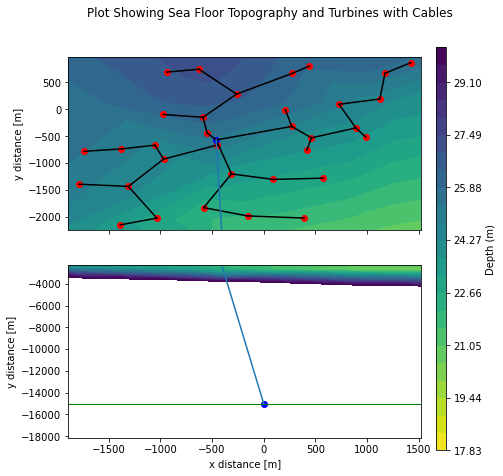

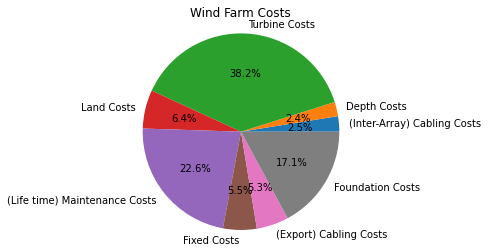

In [121]:
## GUASSIAN LAYOUT AND GAUSSIAN TESTING
## INPUTS (DO NOT OVERWRITE): smallestpositionlist, smallestindiceslist, OptimizedTPO, smallestTotalCost
## Calculates results for the optimised positionlist
distance,angle,distance_global,angle_global = geom_analysis(smallestpositionlist,smallestindiceslist)
MSTweight = Minimum_Spanning_Tree(distance,smallestindiceslist)
wsr=windspeedreduction(positionlist[1:,:],angles,predict_class)
powout=power(wsr,velocities) # total output power
output=np.tensordot(powout,wsp,axes=2)
print(f'positionlist[1:,:].shape = {positionlist[1:,:].shape}\n angles.shape = {angles.shape}')
## Below calculates max theoreticl power output
wsr_noWake = np.multiply(0.92477772, np.ones(wsr.shape))  ## 0.92477772 is not 1 because of the impact of the hub height
powout_noWake = power(wsr_noWake,velocities)
output_noWake=np.tensordot(powout_noWake,wsp,axes=2)
theoretical_max_power = np.sum(output_noWake)

## Displays imported optimised layout
print('\033[1m'+'\033[4m'+'POST-OPTIMISED LAYOUT INFORMATION (GAUSSIAN LAYOUT & TESTING)'+'\033[0m'+'\033[0m')
print()
OptimizedTPO = smallestTotalCost/smallestCostPerWatt
plotting_function(smallestpositionlist,smallestindiceslist,MSTweight,data,OnshoreSubstation,smallestExportDistance)
OptimizedPayBackTime,OptimizedDiscountedPayBackTime,OptimizedNPV,OptimizedProfIndex = Payback(OptimizedTPO,smallestTotalCost,smallestpositionlist)
print('\033[1m'+'Total Power Output:'+'\033[0m', OptimizedTPO, 'W')
print('\033[1m'+'Theoretical Max Total Power Output:'+'\033[0m', theoretical_max_power, 'W')
print('\033[1m'+'Percentage power lost to wake effcts:'+'\033[0m', (1-(OptimizedTPO/theoretical_max_power))*100, '%')
print('\033[1m'+'Cost per Watt'+'\033[0m',smallestCostPerWatt,'£/W')
print('')
print('\033[1m'+'Payback Time:'+'\033[0m',OptimizedPayBackTime,'years')
print('\033[1m'+'Discounted Payback Time:'+'\033[0m',OptimizedDiscountedPayBackTime,'years')
print('\033[1m'+'NPV: £'+'\033[0m',OptimizedNPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
print('\033[1m'+'Profitability Index: £'+'\033[0m',OptimizedProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

POST-OPTIMISED LAYOUT INFORMATION (IMPORTED LAYOUT W/ GAUSSIAN TESTING)

Maximum turbines per MST: 10
Number of turbines: 33

Inter-Array Cabling Costs: £ 5822136.780256063
Export Cabling Costs: £ 10272806.52704613
Depth Cost: £ 4629718.529594594
Foundations Cost: £ 33043182.50033414
Turbine Cost: £ 73279052.55366394
Land Cost: £ 18474874.085147414
Maintenance Cost: £ 43230000.0
Fixed Cost: 10607142.857142856

Budget: £ 200000000.0
Total Cost: £ 199358913.83318514
Total Power Output: 20779835.079969186 W
Theoretical Max Total Power Output: 24878489.21757952 W
Percentage power lost to wake effcts: 16.47469065249414 %
Cost per Watt 9.525927431235933 £/W

Payback Time: 8.230305442868968 years
Discounted Payback Time: 12.685859975646563 years
NPV: £ 56849596.25403726 over a  20 year period
Profitability Index: £ 1.2871957570779091 over a  20 year period


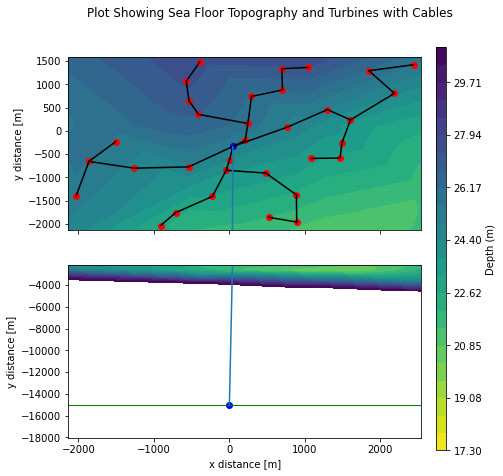

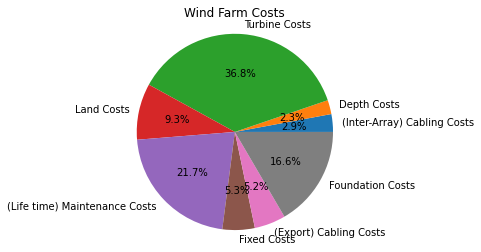

In [70]:
## IMPORTED LAYOUT AND GAUSSIAN TESTING
## note: only valid for the same parameters as the code that generated this layout
## IMPORT ATTENUATION LAYOUT
import pickle
with open('optimised_farm_variables.pkl', 'rb') as f:
    my_variables = pickle.load(f)
PositionList_imported = my_variables['smallestpositionlist'] ## valid import
IndicesList_imported = my_variables['smallestindiceslist'] ## valid import
ExportDistance_imported = my_variables['smallestExportDistance'] ## valid import
MSTWeightSum_imported = my_variables['MSTWeightSum'] ## valid import (total length of cabling)(this import breaks the idea of a position only import, but I don't understand the MST rn)

## Calculates various financial data relating to the position list imported
OnshoreSubstation,ExportDistance_exp = Substation_To_Shore_Connection(PositionList_imported)
FoundationCostTotal_exp = foundations(PositionList_imported)
ExportCableCost_exp = (ExportDistance_imported*ExportCableCostperMeter) # Export cable cost
FixedCost_exp = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*TurbineRating*nturb
CableCost_exp = (MSTWeightSum_imported/1000)*IACableCostperMeter
DepthCostAll_exp = depthvalues(PositionList_imported)[0]
TurbineCostTotal_exp = (nturb)*CostperTurbine
MaintenanceCosts_exp = (nturb)*MaintenanceCostperTurbine
LandCost_exp = LandAreaCost(PositionList_imported,ExportDistance_imported)
TotalCost_exp = TurbineCostTotal_exp+DepthCostAll_exp+MaintenanceCosts_exp+FixedCost_exp+LandCost_exp+CableCost_exp+ExportCableCost_exp+FoundationCostTotal_exp

## Calculates results for the imported optimised positionlist
distance_exp,angle,distance_global,angle_global = geom_analysis(PositionList_imported,IndicesList_imported)
MSTweight = Minimum_Spanning_Tree(distance_exp,IndicesList_imported)
wsr_exp = windspeedreduction(PositionList_imported[1:,:],angles,predict_class)
powout_exp = power(wsr_exp,velocities) # total output power
output_exp = np.tensordot(powout_exp,wsp,axes=2)
TotalPower_exp = np.sum(output_exp)
CostPerWatt_exp = TotalCost_exp/TotalPower_exp

## Below calculates max theoretical power output
wsr_noWake = np.multiply(0.92477772, np.ones(wsr_exp.shape))  ## 0.92477772 is not 1 because of the impact of the hub height
powout_noWake = power(wsr_noWake,velocities)
output_noWake=np.tensordot(powout_noWake,wsp,axes=2)
TotalPower_noWake = np.sum(output_noWake)

## Displays imported optimised layout
print('\033[1m'+'\033[4m'+'POST-OPTIMISED LAYOUT INFORMATION (IMPORTED LAYOUT W/ GAUSSIAN TESTING)'+'\033[0m'+'\033[0m')
print()
plotting_function(PositionList_imported,IndicesList_imported,MSTweight,data,OnshoreSubstation,ExportDistance_imported)
OptimizedPayBackTime,OptimizedDiscountedPayBackTime,OptimizedNPV,OptimizedProfIndex = Payback(TotalPower_exp,TotalCost_exp,PositionList_imported)
print('\033[1m'+'Total Power Output:'+'\033[0m', TotalPower_exp, 'W')
print('\033[1m'+'Theoretical Max Total Power Output:'+'\033[0m', TotalPower_noWake, 'W')
print('\033[1m'+'Percentage power lost to wake effcts:'+'\033[0m', (1-(TotalPower_exp/TotalPower_noWake))*100, '%')
print('\033[1m'+'Cost per Watt'+'\033[0m',CostPerWatt_exp,'£/W')
print('')
print('\033[1m'+'Payback Time:'+'\033[0m',OptimizedPayBackTime,'years')
print('\033[1m'+'Discounted Payback Time:'+'\033[0m',OptimizedDiscountedPayBackTime,'years')
print('\033[1m'+'NPV: £'+'\033[0m',OptimizedNPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
print('\033[1m'+'Profitability Index: £'+'\033[0m',OptimizedProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

In [ ]:
# 8 turbines produce 6MW of output, which is 37.5% of their max output, which is roughly correct.
# If the wind speed decreases by half, power production decreases by a factor of eight.
# On average, therefore, wind turbines do not generate near their capacity.
# Industry estimates project an annual output of 30-40%, but real-world experience shows that
# annual outputs of 15-30% of capacity are more typical in a year. Therefore this improved 37.5% is good.

In [ ]:
print(res.success) # whether the minization was succesful or not
print(res.status) # termination status
print(res.message) # Description of the cause of termination
print(res.nit) # number of iterations performed by the optimizer

In [74]:
import timeit as timeit
flat_coords=positionlist[1:,:].flatten()
timeit.timeit('targetfunction(flat_coords)',number=3)

NameError: name 'targetfunction' is not defined